In [2]:
import numpy as np
import nrrd
import matplotlib.pyplot as plt
from typing import List, Tuple
from repertoire import *
from skimage.morphology import erosion, dilation, disk
from statistics import mean, pvariance
import pandas as pd
from skimage.feature import local_binary_pattern
from scipy.stats import entropy
import os

In [3]:
def display_six_plot_two_acq(features_list1: list, features_list2: list, suptitle : str) -> None:
    """
    This functions displays 6 graphs in 2 rows, 3 columns with only one curve in each plot.

    Args : 
        features_list (list) : list of 6 features (contrast, correlation, dissimilarity, homogeneity, ASM, entropy) 
                               for a patient. Each feature is a numpy.ndarray type;   
        suptitle (str) : suptitle for the 6 graphs.
    
    Returns : 
        NoneType : 6 graphs showing the evolution of each feature as a function of acquisitions.    
    """
    plt.figure(figsize = (12,6))

    title_list = ["Entropy", "Energy"]
    for i in range(2):

        plt.subplot(1,2, i+1)
        plt.plot(features_list1[i],marker = 'o', color = "#69B3A2", label = "Acquisition 1")
        plt.plot(features_list2[i],marker = 'o', color = "indianred", label = "Acquisition 2")
        plt.title(title_list[i],fontsize=18)
        plt.grid(True)
        plt.xlabel("Image 3D cuts", fontsize = 18)
        plt.ylabel("Feature", fontsize = 18)
        plt.legend()

    plt.suptitle(suptitle, fontsize=20)
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()

In [4]:
def display_two_plot_entropy(feature1_mean): 
    plt.figure(figsize=(12,6))
    colormap = ["#69B3A2","indianred","darkgrey","goldenrod","slateblue","olive","steelblue","palevioletred",
                "peru", "darkseagreen"]
    colormap2 = ["violet","navy","tan","brown", "salmon", "yellowgreen", "aqua",
                "deepskyblue"]
    patient_label = ["IH1", "CB2", "HT1", "CA1", "ET1", "SLT", "JH1", "MK1", "SR1", "AV1", "AB2", "SB1", "FB1", "CS1", "CB1", "PG", "YG","IR"]
    feature1_mean_x = feature1_mean[:10]
    feature1_mean_xx = feature1_mean[11:]
    plt.subplot(1,2,1)
   
    for j in range(len(feature1_mean_x)):
        plt.plot(feature1_mean_x[j], marker = 'o', color = colormap[j], label = patient_label[j])
        plt.xlim(-10,105)
        plt.ylim(2.4, 3.6)
        plt.grid(True)
        plt.title("Entropy values for subject 1 to 10", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

    plt.subplot(1,2,2)
   
    for j in range(len(feature1_mean_xx)):
        plt.plot(feature1_mean_xx[j], marker = 'o', color = colormap2[j], label = patient_label[j])
        plt.xlim(-10,105)
        plt.ylim(2.4, 3.6)
        plt.grid(True)
        plt.title("Entropy values for subject 1 to 10", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)


In [5]:
def display_two_plot_energy(feature1_mean): 
    plt.figure(figsize=(12,6))
    colormap = ["#69B3A2","indianred","darkgrey","goldenrod","slateblue","olive","steelblue","palevioletred",
                "peru", "darkseagreen"]
    colormap2 = ["violet","navy","tan","brown", "salmon", "yellowgreen", "aqua",
                "deepskyblue"]
    patient_label = ["IH1", "CB2", "HT1", "CA1", "ET1", "SLT", "JH1", "MK1", "SR1", "AV1", "AB2", "SB1", "FB1", "CS1", "CB1", "PG", "YG","IR"]
    feature1_mean_x = feature1_mean[:10]
    feature1_mean_xx = feature1_mean[11:]
    plt.subplot(1,2,1)
   
    for j in range(len(feature1_mean_x)):
        plt.plot(feature1_mean_x[j], marker = 'o', color = colormap[j], label = patient_label[j])
        plt.xlim(-10,105)
        plt.ylim(0.02,0.32)
        plt.grid(True)
        plt.title("Energy values for subject 1 to 10", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

    plt.subplot(1,2,2)
   
    for j in range(len(feature1_mean_xx)):
        plt.plot(feature1_mean_xx[j], marker = 'o', color = colormap2[j], label = patient_label[j])
        plt.xlim(-10,105)
        plt.ylim(0.02,0.32)
        plt.grid(True)
        plt.title("Energy values for subject 10 to 20", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

In [6]:
def variance_intra_individuelle_energy_entropy(feature_energy: List[List[float]], feature_entropy: List[List[float]]) -> Tuple[List[float], List[float]]:
    """
    Calcule la moyenne et la variance intra-individuelle (au sein d’un même patient)
    pour l’énergie et l’entropie, respectivement.

    Args:
        feature_energy (list): liste [patient][coupe] contenant les énergies moyennes
        feature_entropy (list): liste [patient][coupe] contenant les entropies moyennes

    Returns:
        Tuple contenant :
        - liste des moyennes [energie_patient_0, ..., energie_patient_n, entropie_patient_0, ..., entropie_patient_n]
        - liste des variances correspondantes
    """
    mean_per_patient = []
    variance_intra = []

    for patient_features in feature_energy:
        mean_per_patient.append(mean(patient_features))
        variance_intra.append(pvariance(patient_features))

    for patient_features in feature_entropy:
        mean_per_patient.append(mean(patient_features))
        variance_intra.append(pvariance(patient_features))

    return mean_per_patient, variance_intra

def plot_variance_intraindividuelle_energy_entropy(mean_energy: List[List[float]], mean_entropy: List[List[float]], suptitle: str) -> None:
    """Affiche la variance intra-individuelle énergie/entropie pour tous les patients.

    Args:
        mean_energy (list): liste [patient][coupe] des énergies moyennes
        mean_entropy (list): liste [patient][coupe] des entropies moyennes
        suptitle (str): titre général de la figure
    """
    mean_vals, var_vals = variance_intra_individuelle_energy_entropy(mean_energy, mean_entropy)

    patients = ["IH1", "CB2", "HT1", "CA1", "ET1", "SLT", "JH1", "MK1", "SR1", "AV1", "AB2", "SB1", "FB1", "CS1", "CB1", "PG", "YG","IR"]
    feature_names = ["Energy", "Entropy"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    handles = None
    labels = None

    for i in range(2):  # 0: energy, 1: entropy
        ax = axes[i]
        means = mean_vals[i * len(patients):(i + 1) * len(patients)]
        variances = var_vals[i * len(patients):(i + 1) * len(patients)]
        half_std = [np.sqrt(v)/2 for v in variances]
        lower = [m - h for m, h in zip(means, half_std)]
        upper = [m + h for m, h in zip(means, half_std)]

        _ = ax.vlines(patients, ymin=lower, ymax=upper, colors='b', lw=2, label="1/2 écart-type")
        _ = ax.scatter(patients, lower, color='r', label="Borne min")
        _ = ax.scatter(patients, upper, color='g', label="Borne max")
        _ = ax.scatter(patients, means, color='orange', label="Moyenne")

        ax.set_xticks(patients)
        ax.set_xticklabels([f'Subject {i}' for i in patients], rotation=45, ha='right')
        ax.set_title(feature_names[i], fontsize=18)
        ax.grid(True, linestyle='--', alpha=0.6)

        if handles is None:
            handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12)
    fig.suptitle(suptitle, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 0.88, 0.95])

    plt.show()

In [7]:
def cv_robuste_mad(acq1: np.ndarray,acq2: np.ndarray) -> float:      ## NE PAS UTILISER CETTE FONCTION
    """
    This function returns a coefficient of variation caclculated around the median, that helps to ignore extreme value of the date; the median is more robust to extreme values ​​than the mean

    Args:
        acq1 (np.ndarray): Containing average on the volume -> one Haralick value per patient for the first acquisition.
        acq2 (np.ndarray): Containing average on the volume -> one Haralick value per patient for the second acquisition.

    Returns:
        float: CV in % corresponding to the coefficient of variation between two acquisitions. More CV is low, better it is. 
    """
    x = np.array(acq1)
    y = np.array(acq2)

    diff = x-y 

    median_diff = np.median(x-y)

    mad = np.median(np.abs(diff-median_diff))

    mean_central = np.mean([np.median(x), np.median(y)])

    cv_robuste = mad/mean_central
    return cv_robuste*100

In [14]:
def crooped_rectangle(volume): #volume de taille (i lignes, j colonnes, k coupes)
    debut_ligne = 0
    fin_ligne = 0

    debut_colonne = 0
    fin_colonne = 0
    for i in range(volume.shape[0]): 
        if np.min(volume[i,:])!=0: 
            debut_ligne = i
    for i in range(debut_ligne, volume.shape[0]): 
        if np.min(volume[i,:]) ==0: 
            fin_ligne = i-1

    for i in range(volume.shape[1]): 
        if np.min(volume[:,i])!=0: 
            debut_colonne = i
    for i in range(debut_ligne, volume.shape[0]): 
        if np.min(volume[:,i]) ==0: 
            fin_colonne = i-1
    return debut_ligne, fin_ligne, debut_colonne, fin_colonne

In [83]:
def LBP_treatement(echo_acq1, seg_acq1, frame_start1, frame_end1, echo_acq2, seg_acq2, frame_start2, frame_end2, n_points, radius, suptitle): 

    # Ouvrir la segmentation de la première acquisition 
    pre_tendon1 = echo_acq1*(seg_acq1>0)
    tendon1 = np.rot90(pre_tendon1, k = 3)

    # Ouvrir la segmentation de la deuxième acquisition
    pre_tendon2 = echo_acq2*(seg_acq2>0)
    tendon2 = np.rot90(pre_tendon2, k = 3)

    tendon_erode_acq1 = np.zeros_like(tendon1)
    tendon_erode_acq2 = np.zeros_like(tendon2)

    lbp_energy1 = []
    lbp_entropy1 = []

    lbp_energy2 = []
    lbp_entropy2 = []

    for i in range(tendon1.shape[2]): # boucle qui va de 0 à 82 coupes

        # Erosion des tendons pour enlever la gaine 
        tendon_erode_acq1[:,:,i] = dilation(erosion(tendon1[:,:,i], disk(1)), disk(1))       # Volume de 83 coupes contenant uniquement la segmentation qui commence à 260 jusqu'à 343
        tendon_erode_acq2[:,:,i] = dilation(erosion(tendon2[:,:,i], disk(1)), disk(1))       # Volume de 83 coupes contenant uniquement la segmentation qui commence à 246 jusqu'à 329
        
    for i in range(frame_start1, frame_end1):
        # Analyse de LBP pour la première acquisition
        lbp = local_binary_pattern(tendon_erode_acq1[:,:,i], n_points, radius)
        
        hist,_ = np.histogram(lbp.ravel(), bins = int(lbp.max()+1), range =(0,int(lbp.max()+1)), density = True)
        lbp_entropy1.append(entropy(hist))
        lbp_energy1.append(np.sum(hist**2))

    for i in range(frame_start2, frame_end2):

        # Analyse de LBP pour la deuxième acquisition

        lbp2 = local_binary_pattern(tendon_erode_acq2[:,:,i], n_points, radius)
      
        hist2,_ = np.histogram(lbp2.ravel(), bins = int(lbp2.max()+1), range = (0,int(lbp2.max()+1)), density = True)
        lbp_entropy2.append(entropy(hist2))
        lbp_energy2.append(np.sum(hist2**2))

    entropy_mean = np.mean((np.array(lbp_entropy1), np.array(lbp_entropy2)))
    energy_mean = np.mean((np.array(lbp_energy1), np.array(lbp_energy2)))

    display_six_plot_two_acq([lbp_entropy1, lbp_energy1], [lbp_entropy2, lbp_energy2], suptitle)

    CV_entropy = (np.sqrt((np.sum((np.array(lbp_entropy1)-np.array(lbp_entropy2))**2))/(2*(frame_end1-frame_start1)))/((np.mean(lbp_entropy1)+np.mean(lbp_entropy2))/2))*100
    CV_energy = (np.sqrt((np.sum((np.array(lbp_energy1)-np.array(lbp_energy2))**2))/(2*(frame_end1-frame_start1)))/((np.mean(lbp_energy1)+np.mean(lbp_energy2))/2))*100 

    print("Le coefficient de variation de l'entropie entre les deux acquisitions est "+str(CV_entropy))
    print("Le coefficient de variation de l'énergie entre les deux acquisitions est " + str(CV_energy))

    return [lbp_entropy1, lbp_energy1], [lbp_entropy2, lbp_energy2], [entropy_mean, energy_mean]

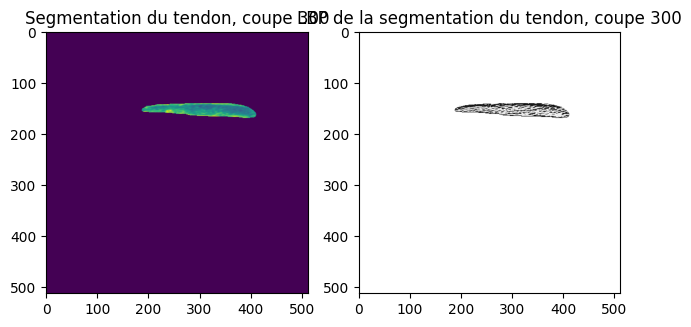

In [29]:
# Comparaison segmentation avant et après LBP 
pre_tendon1 = echo_IH1_acq1_trans*(seg_IH1_acq1_trans>0)
tendon1 = np.rot90(pre_tendon1, k = 3)

img = tendon1[:,:,300]
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Segmentation du tendon, coupe 300")

plt.subplot(1,2,2)
lbp = local_binary_pattern(img, 8, 1)
plt.imshow(lbp,"gray")
plt.title("LBP de la segmentation du tendon, coupe 300")

plt.tight_layout()

### Analyse d'ordre supérieur avec les bonnes coupes de segmentations de tendons. 

In [12]:
echo_IH1_acq1_trans, _ = nrrd.read(r"C:\Users\rmohane\Desktop\base_de_donnees\TP\IH1c\IH1 VF TP1/IH1 VF T  TP2.nrrd")
seg_IH1_acq1_trans, _  = nrrd.read(r"C:\Users\rmohane\Desktop\base_de_donnees\TP\IH1c\IH1 VF TP1/Segmentation.seg.nrrd")

echo_IH1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/IH1c/IH1 VF TP2/IH1 VF T  TP.nrrd")
seg_IH1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/IH1c/IH1 VF TP2/Segmentation.seg.nrrd")

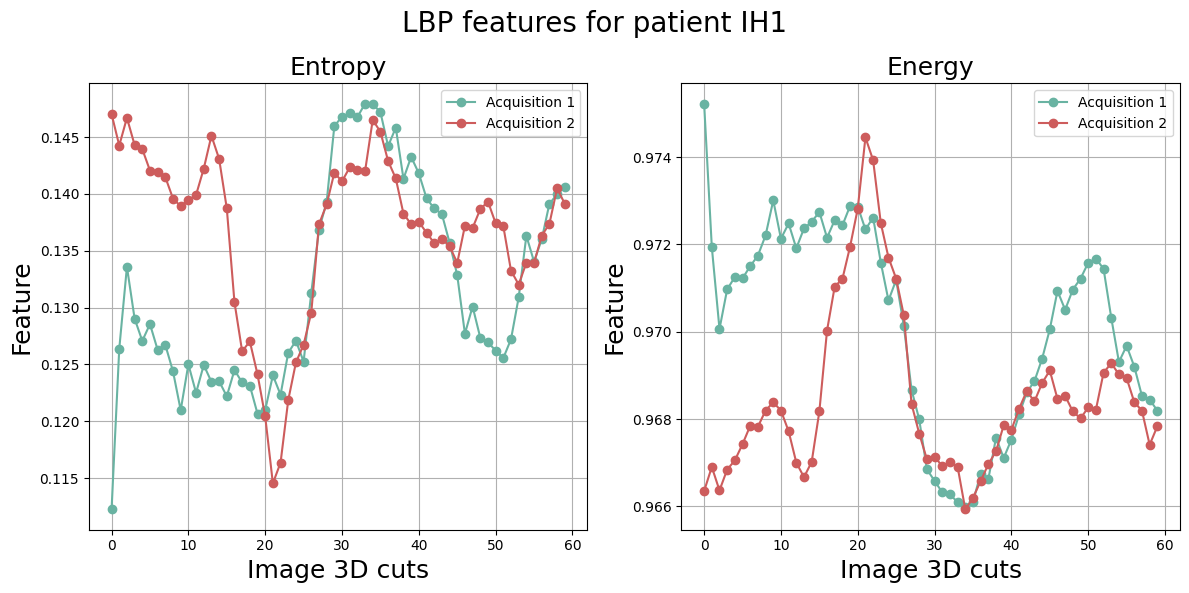

Le coefficient de variation de l'entropie entre les deux acquisitions est 5.492646505586056
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.2021965495353347


In [16]:
IH1_acq1, IH1_acq2, IH1_mean = LBP_treatement(echo_IH1_acq1_trans, seg_IH1_acq1_trans, 259, 319, echo_IH1_acq2_trans, seg_IH1_acq2_trans, 267, 327, 8,1, "LBP features for patient IH1")

In [17]:
echo_CB2_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CB2c/CB2 VF TP1/CB2 VF T TP.nrrd")
seg_CB2_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CB2c/CB2 VF TP1/Segmentation.seg.nrrd")

echo_CB2_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CB2c/CB2 VF TP2/CB2 VF T TP2.nrrd")
seg_CB2_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CB2c/CB2 VF TP2/Segmentation.seg.nrrd")

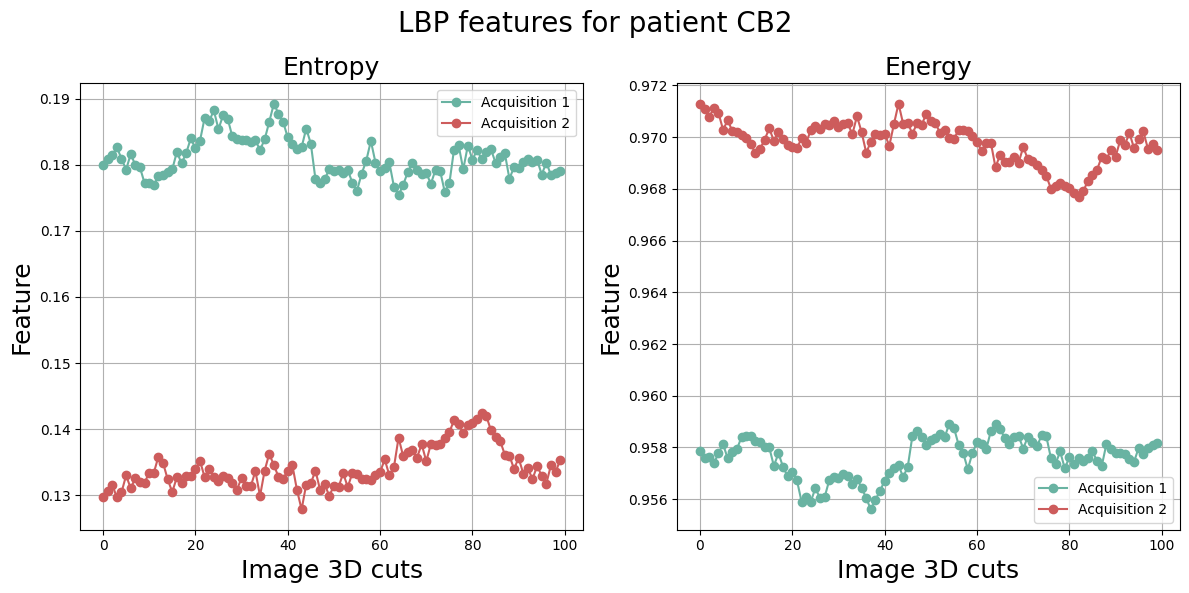

Le coefficient de variation de l'entropie entre les deux acquisitions est 21.110847938370384
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.8975269794621991


In [18]:
CB2_acq1, CB2_acq2, CB2_mean = LBP_treatement(echo_CB2_acq1_trans, seg_CB2_acq1_trans,  204,304, echo_CB2_acq2_trans, seg_CB2_acq2_trans, 224,324, 8,1, "LBP features for patient CB2")

In [19]:
echo_HT1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/HT1c/HT1 VF TP1/HT1 VF TTP.nrrd")
seg_HT1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/HT1c/HT1 VF TP1/Segmentation.seg.nrrd")

echo_HT1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/HT1c/HT1 VF TP2/HT1 VF TTP2.nrrd")
seg_HT1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/HT1c/HT1 VF TP2/Segmentation.seg.nrrd")

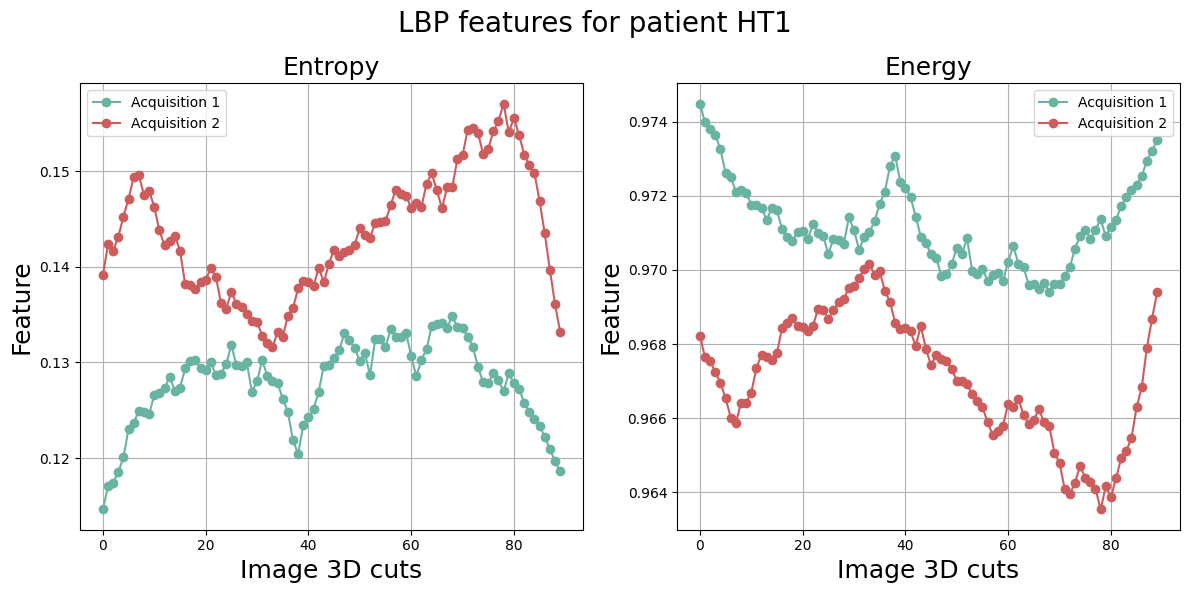

Le coefficient de variation de l'entropie entre les deux acquisitions est 8.890183601481697
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.3253376292961308


In [20]:
HT1_acq1, HT1_acq2, HT1_mean = LBP_treatement(echo_HT1_acq1_trans, seg_HT1_acq1_trans, 258,348, echo_HT1_acq2_trans, seg_HT1_acq2_trans, 253, 343, 8,1, "LBP features for patient HT1")


In [21]:
echo_CA1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CA1c/CA1 VF TP1/CA1 VF T TP.nrrd")
seg_CA1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CA1c/CA1 VF TP1/Segmentation.seg.nrrd")

echo_CA1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CA1c/CA1 VF TP2/CA1 VF T TP2.nrrd")
seg_CA1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CA1c/CA1 VF TP2/Segmentation.seg.nrrd")

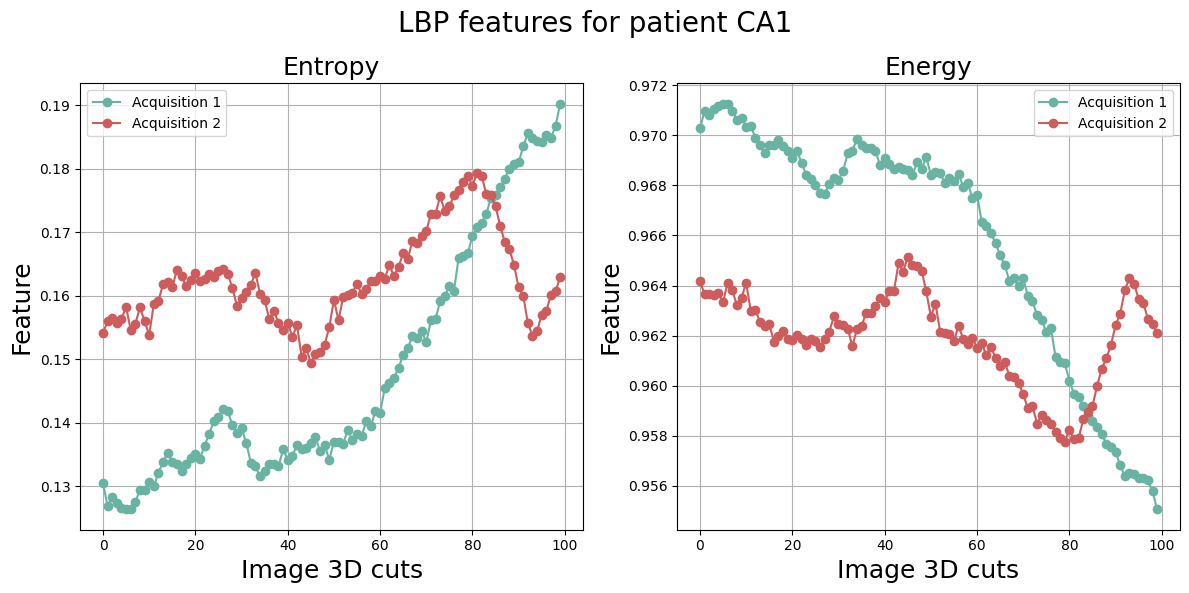

Le coefficient de variation de l'entropie entre les deux acquisitions est 10.016109397622992
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.42490472911675


In [22]:
CA1_acq1, CA1_acq2, CA1_mean = LBP_treatement(echo_CA1_acq1_trans, seg_CA1_acq1_trans, 240,340, echo_CA1_acq2_trans, seg_CA1_acq2_trans,210,310, 8,1, "LBP features for patient CA1")

In [23]:
echo_ET1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/ET1c/ET1 VF TP1/ET1 VF T TP.nrrd")
seg_ET1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/ET1c/ET1 VF TP1/Segmentation.seg.nrrd")

echo_ET1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/ET1c/ET1 VF TP2/ET1 VF TTP2.nrrd")
seg_ET1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/ET1c/ET1 VF TP2/Segmentation_1.seg.nrrd")

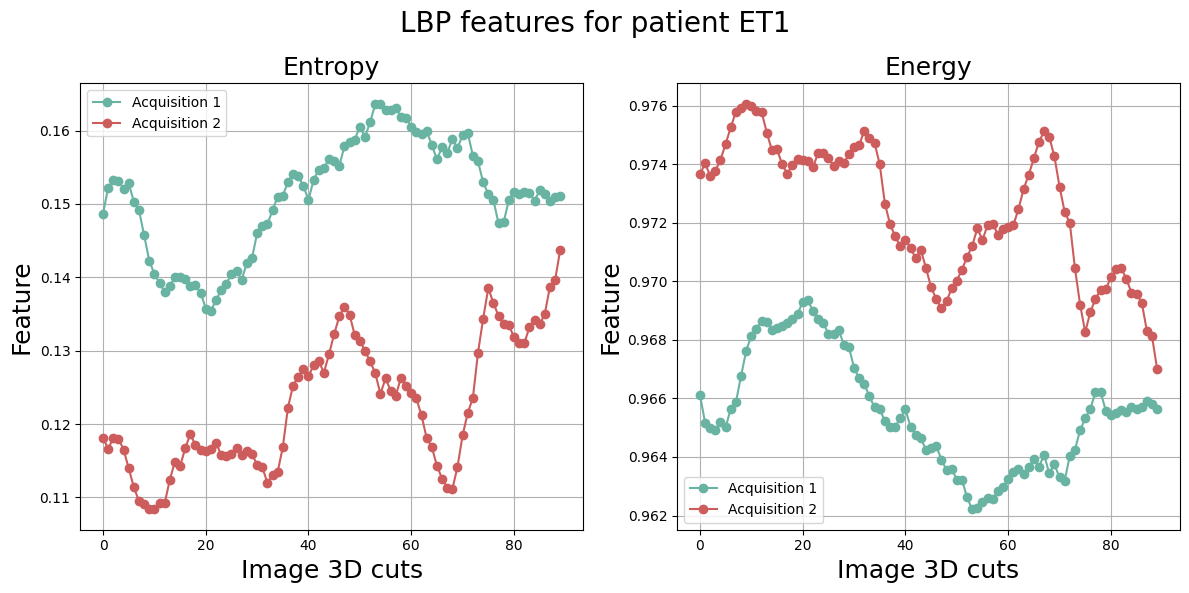

Le coefficient de variation de l'entropie entre les deux acquisitions est 15.46685752025658
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.5296444121672005


In [24]:
ET1_acq1_d1a0, ET1_acq2_d1a0, ET1_mean_d1a0 = LBP_treatement(echo_ET1_acq1_trans, seg_ET1_acq1_trans, 230,320, echo_ET1_acq2_trans, seg_ET1_acq2_trans,227,317, 8,1, "LBP features for patient ET1")

In [25]:
echo_SLT_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SLTc/SLT VF TP1/SLT VF T TP.nrrd")
seg_SLT_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SLTc/SLT VF TP1/Segmentation.seg.nrrd")

echo_SLT_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SLTc/SLT VF TP2/SLT VF T TP2.nrrd")
seg_SLT_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SLTc/SLT VF TP2/Segmentation.seg.nrrd")

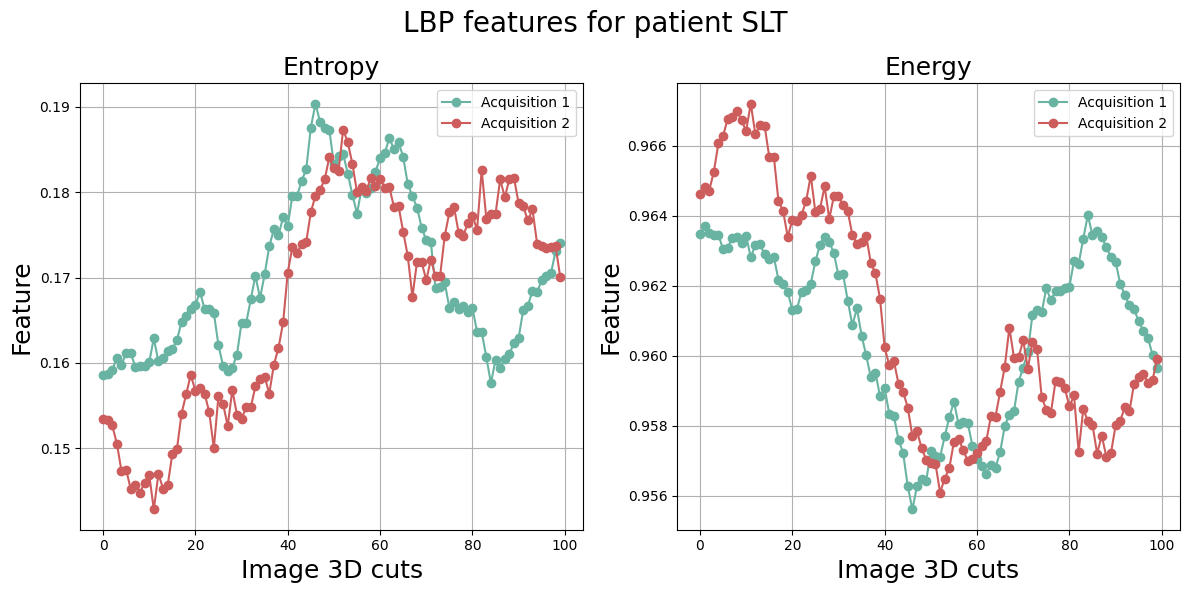

Le coefficient de variation de l'entropie entre les deux acquisitions est 4.448441180132442
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.19955143371698228


In [26]:
SLT_acq1, SLT_acq2, SLT_mean = LBP_treatement(echo_SLT_acq1_trans, seg_SLT_acq1_trans, 230,330, echo_SLT_acq2_trans, seg_SLT_acq2_trans,200,300, 8,1, "LBP features for patient SLT")

In [27]:
echo_JH1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/JH1c/JH1 VF TP1/JH1 VF T TP.nrrd")
seg_JH1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/JH1c/JH1 VF TP1/Segmentation.seg.nrrd")

echo_JH1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/JH1c/JH1 VF TP2/JH1 VF T TP2.nrrd")
seg_JH1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/JH1c/JH1 VF TP2/Segmentation.seg.nrrd")

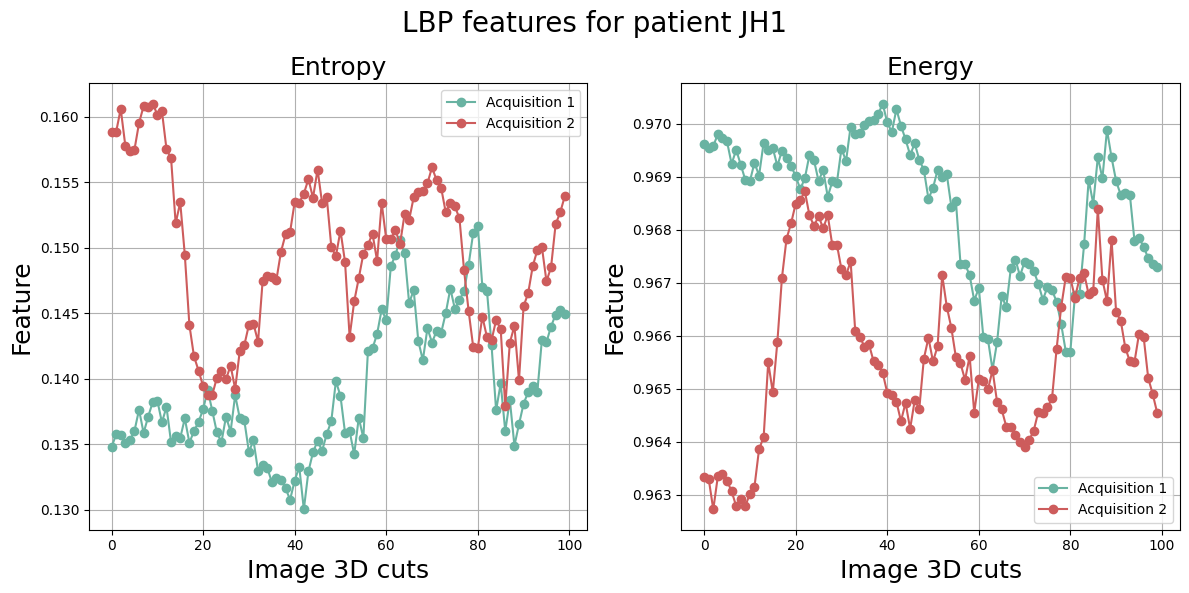

Le coefficient de variation de l'entropie entre les deux acquisitions est 6.467484392858171
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.25625343913743037


In [28]:
JH1_acq1, JH1_acq2, JH1_mean = LBP_treatement(echo_JH1_acq1_trans, seg_JH1_acq1_trans, 232,332, echo_JH1_acq2_trans, seg_JH1_acq2_trans,233,333, 8,1, "LBP features for patient JH1")

In [30]:
echo_MK1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/MK1c/MK1 VF TP1/MK1 VF T TP.nrrd")
seg_MK1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/MK1c/MK1 VF TP1/Segmentation.seg.nrrd")

echo_MK1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/MK1c/MK1 VF TP2/MK1 VF T TP2.nrrd")
seg_MK1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/MK1c/MK1 VF TP2/Segmentation.seg.nrrd")

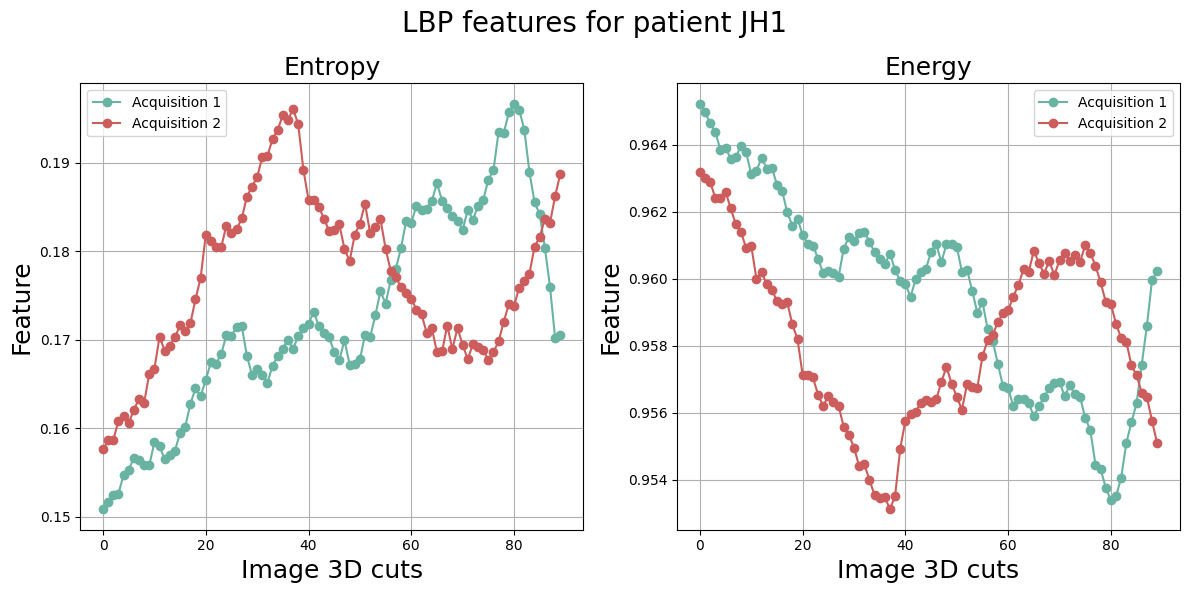

Le coefficient de variation de l'entropie entre les deux acquisitions est 6.042453942872915
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.30441533958477124


In [31]:
MK1_acq1, MK1_acq2, MK1_mean = LBP_treatement(echo_MK1_acq1_trans, seg_MK1_acq1_trans, 172,262, echo_MK1_acq2_trans, seg_MK1_acq2_trans,198,288, 8,1, "LBP features for patient JH1")

In [32]:
echo_SR1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SR1c/SR1 VF TP1/SR1 VF T TP.nrrd")
seg_SR1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SR1c/SR1 VF TP1/Segmentation.seg.nrrd")

echo_SR1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SR1c/SR1 VF TP2/SR1 VF T TP2.nrrd")
seg_SR1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SR1c/SR1 VF TP2/Segmentation.seg.nrrd")

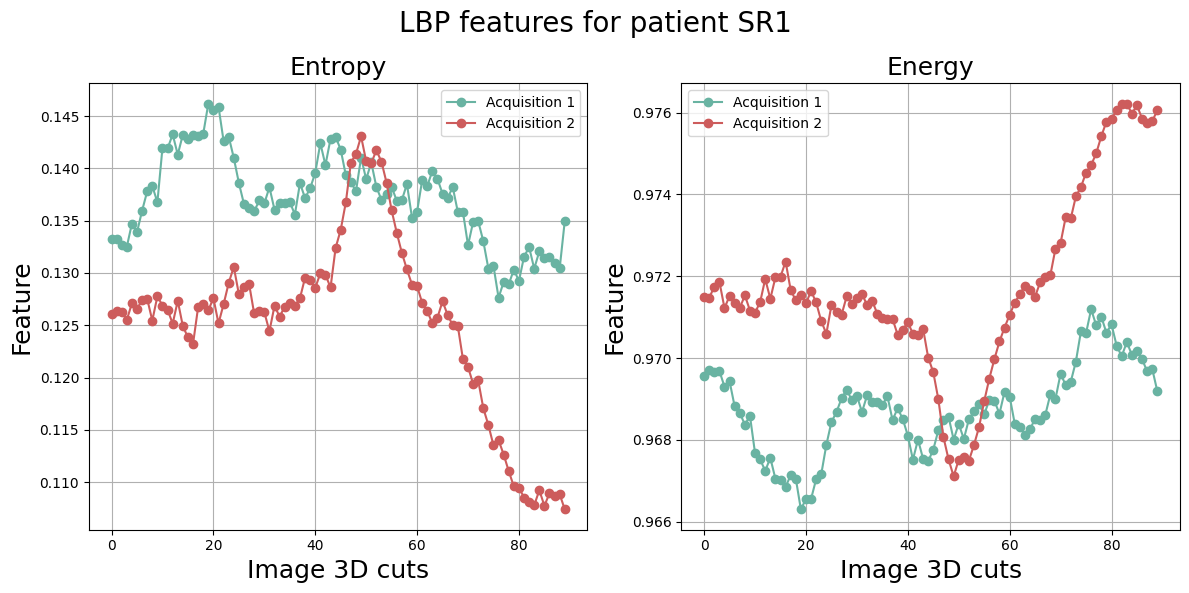

Le coefficient de variation de l'entropie entre les deux acquisitions est 7.367430713197244
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.2561325313343717


In [33]:
SR1_acq1, SR1_acq2, SR1_mean = LBP_treatement(echo_SR1_acq1_trans, seg_SR1_acq1_trans, 215,305, echo_SR1_acq2_trans, seg_SR1_acq2_trans,230,320, 8,1, "LBP features for patient SR1")

In [34]:
echo_AV1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/AV1c/AV1 VF TP1/AV1 VF T TP.nrrd")
seg_AV1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/AV1c/AV1 VF TP1/Segmentation.seg.nrrd")

echo_AV1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/AV1c/AV1 VF TP2/AV1 VF T TP2.nrrd")
seg_AV1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/AV1c/AV1 VF TP2/Segmentation.seg.nrrd")

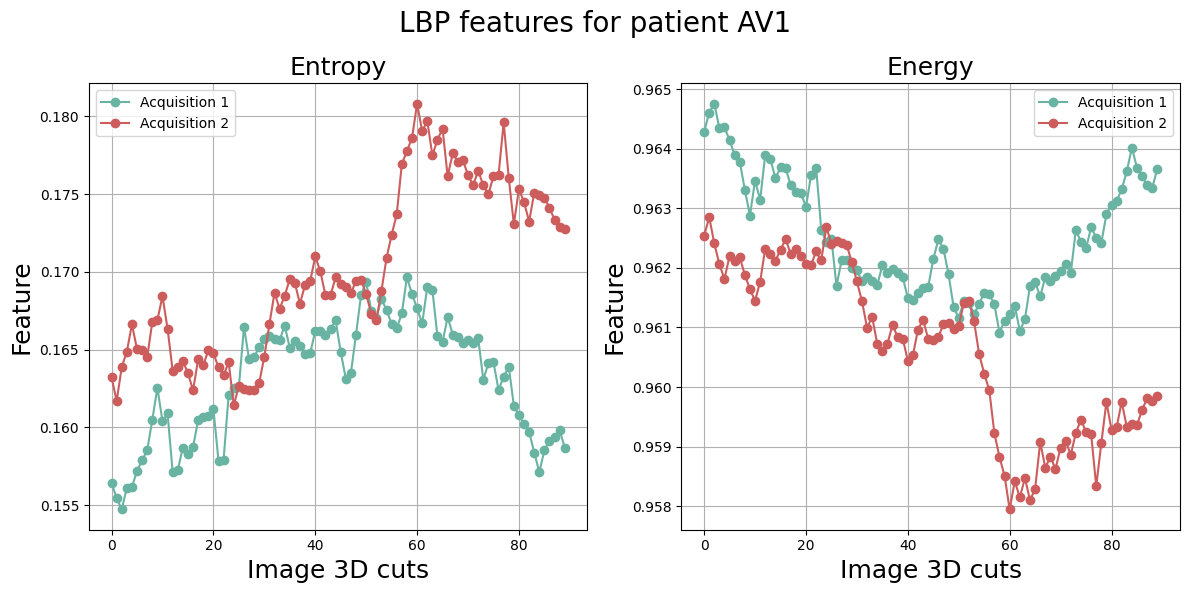

Le coefficient de variation de l'entropie entre les deux acquisitions est 3.651397121589068
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.16622711108787502


In [35]:
AV1_acq1, AV1_acq2, AV1_mean = LBP_treatement(echo_AV1_acq1_trans, seg_AV1_acq1_trans, 220,310, echo_AV1_acq2_trans, seg_AV1_acq2_trans,245,335, 8,1, "LBP features for patient AV1")

In [36]:
echo_AB2_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/AB2c/AB2 VF TP1/AB2 VF T TP.nrrd")
seg_AB2_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/AB2c/AB2 VF TP1/Segmentation.seg.nrrd")

echo_AB2_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/AB2c/AB2 VF TP2/AB2 VF T TP2.nrrd")
seg_AB2_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/AB2c/AB2 VF TP2/Segmentation.seg.nrrd")

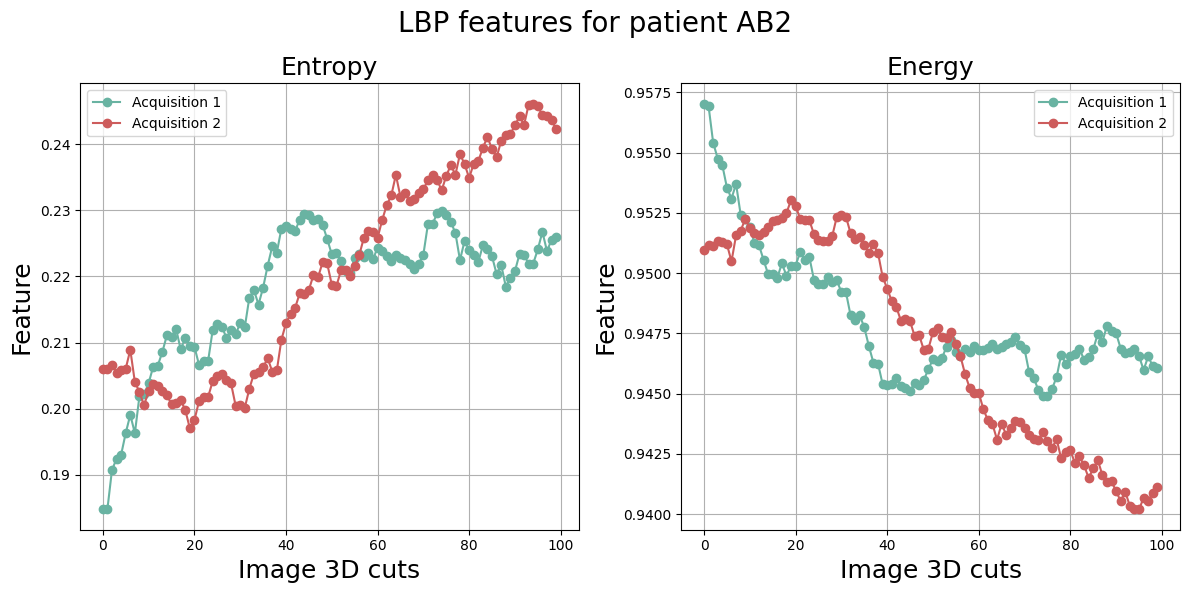

Le coefficient de variation de l'entropie entre les deux acquisitions est 3.9728550288056623
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.2614601186343343


In [37]:
AB2_acq1, AB2_acq2, AB2_mean = LBP_treatement(echo_AB2_acq1_trans, seg_AB2_acq1_trans, 210,310, echo_AB2_acq2_trans, seg_AB2_acq2_trans,225,325, 8,1, "LBP features for patient AB2")

In [38]:
echo_SB1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SB1c/SB1 VF TP1/SB1 VF TTP.nrrd")
seg_SB1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SB1c/SB1 VF TP1/Segmentation.seg.nrrd")

echo_SB1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SB1c/SB1 VF TP2/SB1 VF TTP2.nrrd")
seg_SB1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/SB1c/SB1 VF TP2/Segmentation.seg.nrrd")

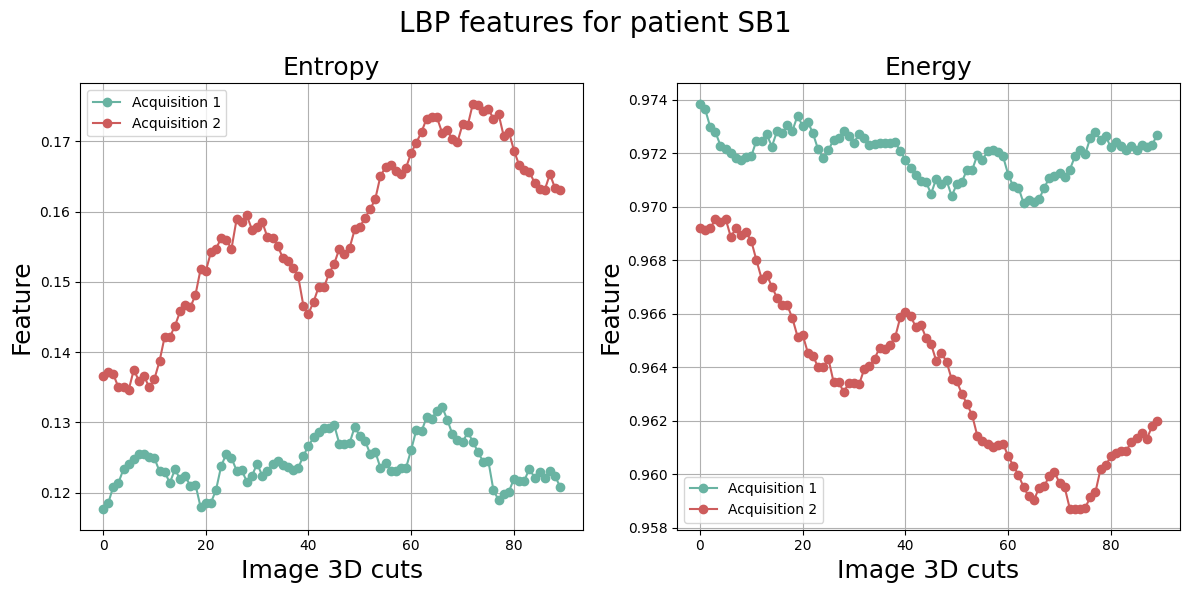

Le coefficient de variation de l'entropie entre les deux acquisitions est 17.50624581534245
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.6546136705229127


In [39]:
SB1_acq1, SB1_acq2, SB1_mean = LBP_treatement(echo_SB1_acq1_trans, seg_SB1_acq1_trans, 225,315, echo_SB1_acq2_trans, seg_SB1_acq2_trans,230,320, 8,1, "LBP features for patient SB1")

In [40]:
echo_FB1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/FB1c/FB1 VF TP1/FB1 VF T- TP.nrrd")
seg_FB1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/FB1c/FB1 VF TP1/Segmentation.seg.nrrd")

echo_FB1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/FB1c/FB1 VF TP2/FB1 VF T- TP2.nrrd")
seg_FB1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/FB1c/FB1 VF TP2/Segmentation.seg.nrrd")

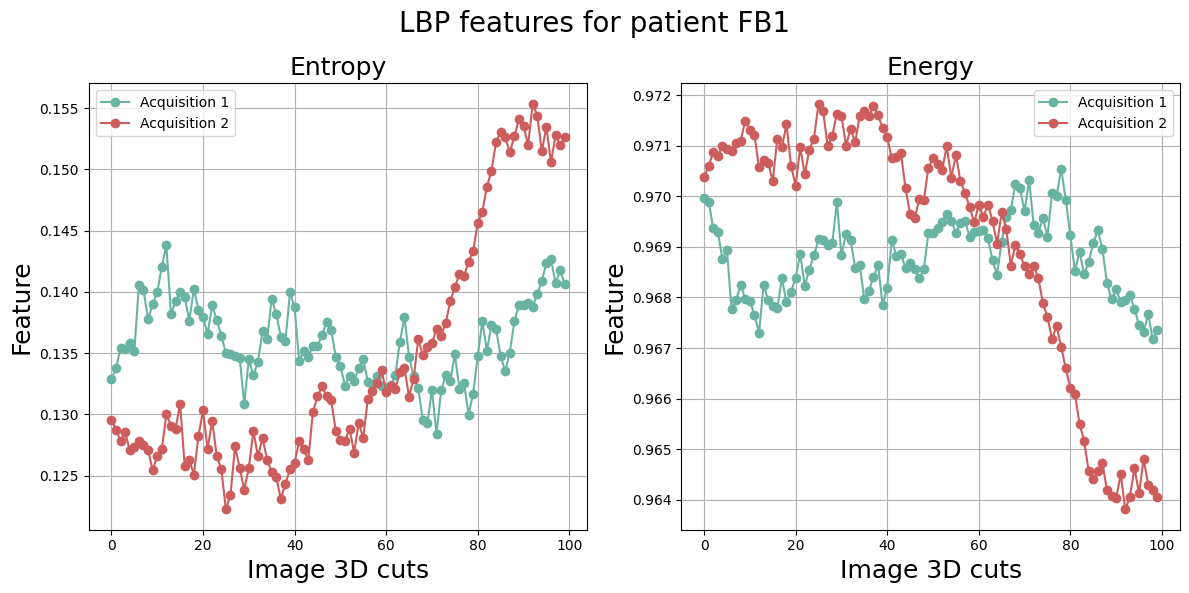

Le coefficient de variation de l'entropie entre les deux acquisitions est 5.181450525276377
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.18578120835220072


In [41]:
FB1_acq1, FB1_acq2, FB1_mean = LBP_treatement(echo_FB1_acq1_trans, seg_FB1_acq1_trans, 260,360, echo_FB1_acq2_trans, seg_FB1_acq2_trans,240,340, 8,1, "LBP features for patient FB1")

In [42]:
echo_CS1_acq1_trans, _ = nrrd.read(r"C:\Users\rmohane\Desktop\base_de_donnees\TP\CS1c\CS1 VF TP1\CS1 VF T TP.nrrd")
seg_CS1_acq1_trans, _  = nrrd.read(r"C:\Users\rmohane\Desktop\base_de_donnees\TP\CS1c\CS1 VF TP1\Segmentation.seg.nrrd")

echo_CS1_acq2_trans, _ = nrrd.read(r"C:\Users\rmohane\Desktop\base_de_donnees\TP\CS1c\CS1 VF TP2\CS1 VF T TP2.nrrd")
seg_CS1_acq2_trans, _  = nrrd.read(r"C:\Users\rmohane\Desktop\base_de_donnees\TP\CS1c\CS1 VF TP2\Segmentation.seg.nrrd")

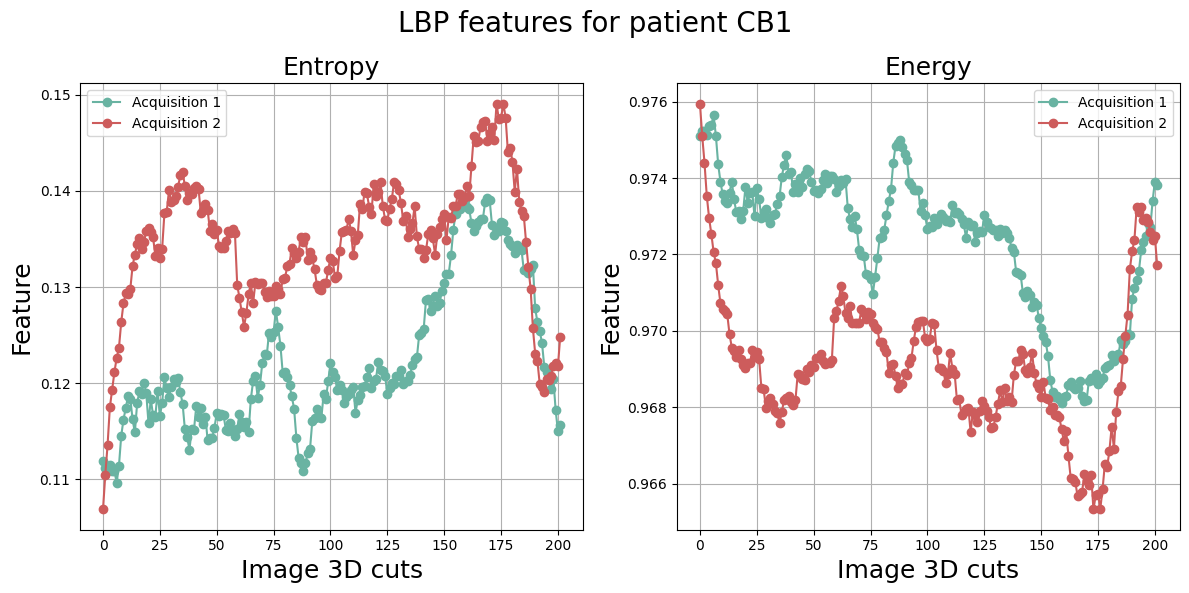

Le coefficient de variation de l'entropie entre les deux acquisitions est 7.913568539717046
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.2657604992697011


In [43]:
CS1_acq1, CS1_acq2, CS1_mean = LBP_treatement(echo_CS1_acq1_trans, seg_CS1_acq1_trans, 260,462, echo_CS1_acq2_trans, seg_CS1_acq2_trans,173,375, 8,1, "LBP features for patient CB1")

In [44]:
echo_CB1_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CB1c/CB1 VF TP1/CB1 VF T TP.nrrd")
seg_CB1_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CB1c/CB1 VF TP1/Segmentation.seg.nrrd")

echo_CB1_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CB1c/CB1 VF TP2/CB1 VF T TP_2.nrrd")
seg_CB1_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/CB1c/CB1 VF TP2/Segmentation.seg.nrrd")

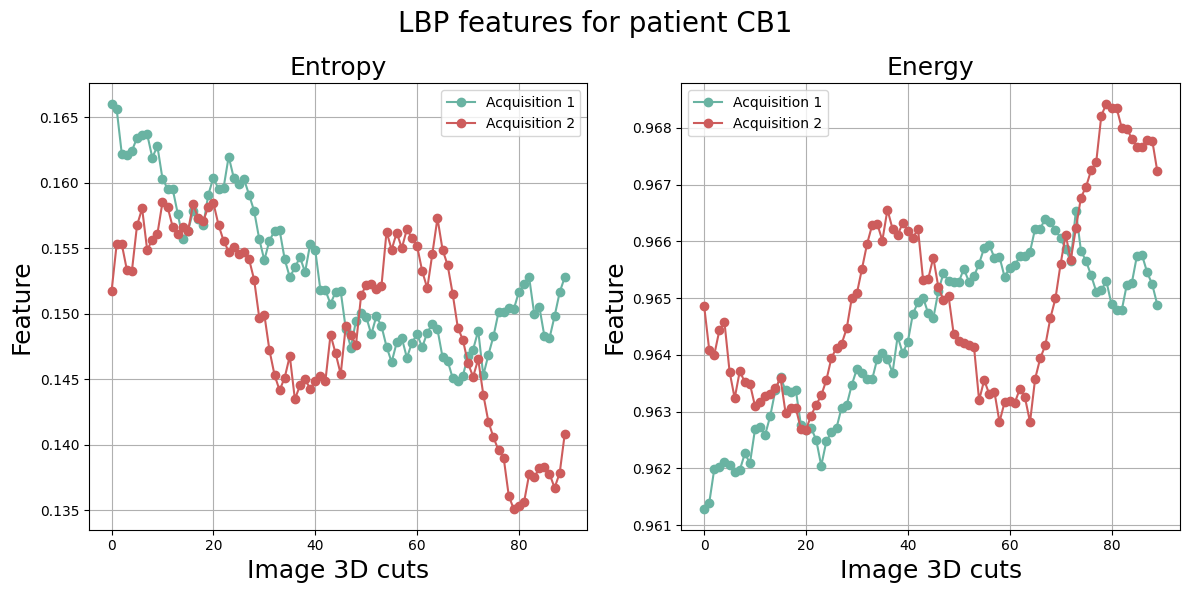

Le coefficient de variation de l'entropie entre les deux acquisitions est 3.6697256391730866
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.13842897510654087


In [45]:
CB1_acq1, CB1_acq2, CB1_mean = LBP_treatement(echo_CB1_acq1_trans, seg_CB1_acq1_trans, 240,330, echo_CB1_acq2_trans, seg_CB1_acq2_trans,265,355, 8,1, "LBP features for patient CB1")

In [46]:
echo_PG_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/PGc/PG VF TP1/PG VF T TP.nrrd")
seg_PG_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/PGc/PG VF TP1/Segmentation.seg.nrrd")

echo_PG_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/PGc/PG VF TP2/PG VF T TP2.nrrd")
seg_PG_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/PGc/PG VF TP2/Segmentation.seg.nrrd")

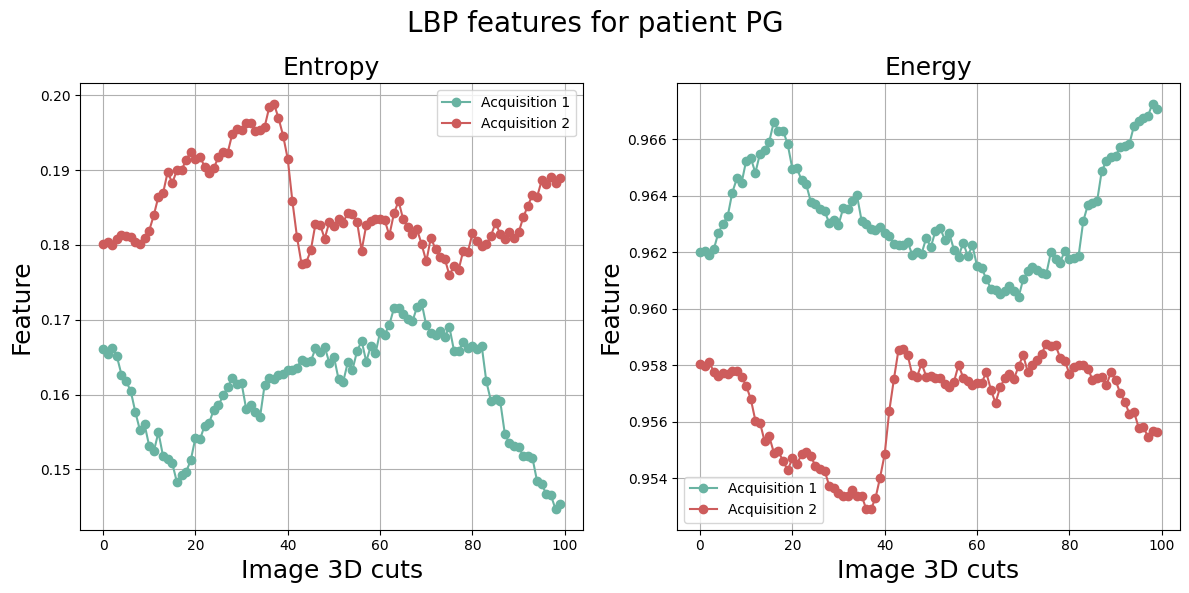

Le coefficient de variation de l'entropie entre les deux acquisitions est 10.889228608731239
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.5377273894027771


In [47]:
PG_acq1, PG_acq2, PG_mean = LBP_treatement(echo_PG_acq1_trans, seg_PG_acq1_trans, 190,290, echo_PG_acq2_trans, seg_PG_acq2_trans,213,313, 8,1, "LBP features for patient PG")

In [48]:
echo_YG_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/YGc/YG VF TP1/YG VF TTP.nrrd")
seg_YG_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/YGc/YG VF TP1/Segmentation.seg.nrrd")

echo_YG_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/YGc/YG VF TP2/YG VF TTP2.nrrd")
seg_YG_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/YGc/YG VF TP2/Segmentation.seg.nrrd")

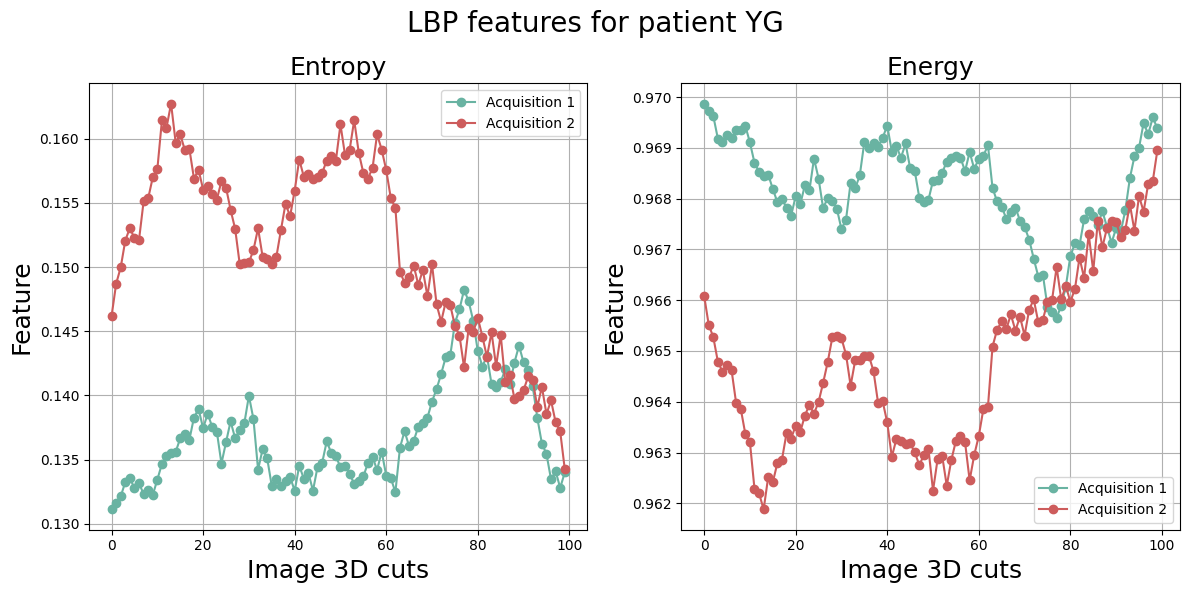

Le coefficient de variation de l'entropie entre les deux acquisitions est 8.50846579611922
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.29767654107080005


In [49]:
YG_acq1, YG_acq2, YG_mean = LBP_treatement(echo_YG_acq1_trans, seg_YG_acq1_trans, 245,345, echo_YG_acq2_trans, seg_YG_acq2_trans,225,325, 8,1, "LBP features for patient YG")

In [50]:
echo_IR_acq1_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/IRc/IR VF TP1/IR VF T TP.nrrd")
seg_IR_acq1_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/IRc/IR VF TP1/Segmentation.seg.nrrd")

echo_IR_acq2_trans, _ = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/IRc/IR VF TP2/IR VF T TP2.nrrd")
seg_IR_acq2_trans, _  = nrrd.read("C:/Users/rmohane/Desktop/base_de_donnees/TP/IRc/IR VF TP2/Segmentation.seg.nrrd")

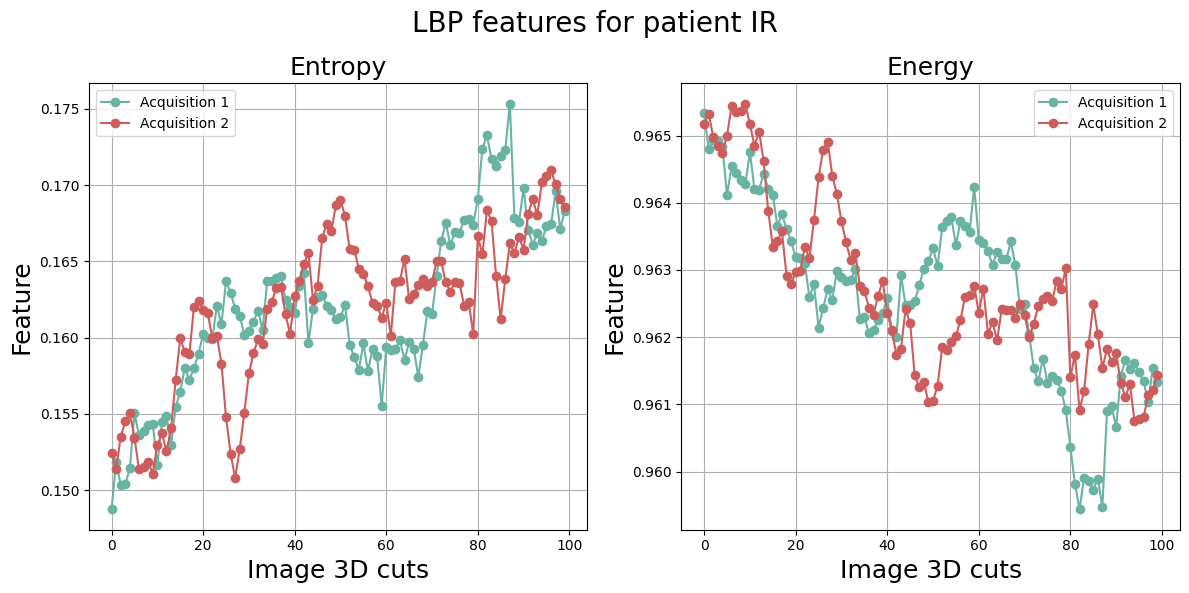

Le coefficient de variation de l'entropie entre les deux acquisitions est 1.9138343861164353
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.08285018808740027


In [51]:
IR_acq1, IR_acq2, IR_mean = LBP_treatement(echo_IR_acq1_trans, seg_IR_acq1_trans, 255,355, echo_IR_acq2_trans, seg_IR_acq2_trans,255,355, 8,1, "LBP features for patient IR")

### Comparaison des features entre acq1 et acq2; calcul du RMSCV

In [52]:
entropy_acq1 = [IH1_acq1[0], CB2_acq1[0], HT1_acq1[0], CA1_acq1[0], ET1_acq1_d1a0[0],
           SLT_acq1[0], JH1_acq1[0], MK1_acq1[0], SR1_acq1[0], 
           AV1_acq1[0], AB2_acq1[0], SB1_acq1[0], FB1_acq1[0], CS1_acq1[0],
           CB1_acq1[0], PG_acq1[0], YG_acq1[0], IR_acq1[0]]

entropy_acq2 = [IH1_acq2[0], CB2_acq2[0], HT1_acq2[0], CA1_acq2[0], ET1_acq2_d1a0[0],
                SLT_acq2[0], JH1_acq2[0], MK1_acq2[0], SR1_acq2[0], 
                AV1_acq2[0], AB2_acq2[0], SB1_acq2[0], FB1_acq2[0], CS1_acq1[0],
                CB1_acq2[0], PG_acq2[0], YG_acq2[0], IR_acq2[0]]

In [53]:
# CV pour énergie 
energy_acq1 = [IH1_acq1[1], CB2_acq1[1], HT1_acq1[1], CA1_acq1[1], ET1_acq1_d1a0[1],
           SLT_acq1[1], JH1_acq1[1], MK1_acq1[1], SR1_acq1[1], 
           AV1_acq1[1], AB2_acq1[1], SB1_acq1[1], FB1_acq1[1], CS1_acq1[1],
           CB1_acq1[1], PG_acq1[1], YG_acq1[1], IR_acq1[1]]

energy_acq2 = [IH1_acq2[1], CB2_acq2[1], HT1_acq2[1], CA1_acq2[1], ET1_acq2_d1a0[1],
                SLT_acq2[1], JH1_acq2[1], MK1_acq2[1], SR1_acq2[1], 
                AV1_acq2[1], AB2_acq2[1], SB1_acq2[1], FB1_acq2[1], CS1_acq2[1],
                CB1_acq2[1], PG_acq2[1], YG_acq2[1], IR_acq2[1]]

In [54]:
# Calcul du cv pour l'entropie 
mean_acq1 = []
for i in range(len(entropy_acq1)): 
    mean_acq1.append(np.mean(entropy_acq1[i]))

mean_acq2 = []
for i in range(len(entropy_acq2)): 
    mean_acq2.append(np.mean(entropy_acq2[i]))

print(cv_robuste_mad(mean_acq1,mean_acq2))

4.791441079161398


In [55]:
# Calcul du CV pour l'énergie
mean_acq1 = []
for i in range(len(energy_acq1)): 
    mean_acq1.append(np.mean(energy_acq1[i]))

mean_acq2 = []
for i in range(len(energy_acq1)): 
    mean_acq2.append(np.mean(energy_acq2[i]))

print(cv_robuste_mad(mean_acq1,mean_acq2))

0.19613262874944573


### Affichage de la variance, et plot tous les sujets 

In [57]:
# calculde la moyenne entre la première et deuxieme acquisition
mean_energy = []
mean_entropy = []

for i in range(len(energy_acq1)):  # boucle sur les patients
    nb_coupes_i = len(energy_acq1[i])  # nombre de coupes pour le patient i
    patient_energy = []
    patient_entropy = []
    
    for j in range(nb_coupes_i):  # boucle sur les coupes de ce patient
        mean_e = (energy_acq1[i][j] + energy_acq2[i][j]) / 2
        mean_h = (entropy_acq1[i][j] + entropy_acq2[i][j]) / 2
        patient_energy.append(mean_e)
        patient_entropy.append(mean_h)
    
    mean_energy.append(patient_energy)
    mean_entropy.append(patient_entropy)

In [58]:
feature1_mean = [IH1_mean[0], CB2_mean[0], HT1_mean[0], CA1_mean[0], ET1_mean_d1a0[0],
           SLT_mean[0], JH1_acq1[0], MK1_mean[0], SR1_mean[0], 
           AV1_mean[0], AB2_mean[0], SB1_mean[0], FB1_mean[0], CS1_mean[0],
           CB1_mean[0], PG_mean[0], YG_mean[0], IR_mean[0]]

feature2_mean = [IH1_mean[1], CB2_mean[1], HT1_mean[1], CA1_mean[1], ET1_mean_d1a0[1],
           SLT_mean[1], JH1_acq1[1], MK1_mean[1], SR1_mean[1], 
           AV1_mean[1], AB2_mean[1], SB1_mean[1], FB1_mean[1], CS1_mean[1],
           CB1_mean[1], PG_mean[1], YG_mean[1], IR_mean[1]]

In [75]:
def display_two_plot_entropy(feature1_mean): 
    plt.figure(figsize=(12,6))
    colormap = ["#69B3A2","indianred","darkgrey","goldenrod","slateblue","olive","steelblue","palevioletred",
                "peru", "darkseagreen"]
    colormap2 = ["violet","navy","tan","brown", "salmon", "yellowgreen", "aqua",
                "deepskyblue"]
    patient_label = ["IH1", "CB2", "HT1", "CA1", "ET1", "SLT", "JH1", "MK1", "SR1", "AV1", "AB2", "SB1", "FB1", "CS1", "CB1", "PG", "YG","IR"]
    feature1_mean_x = feature1_mean[:10]
    feature1_mean_xx = feature1_mean[11:]
    plt.subplot(1,2,1)
   
    for j in range(len(feature1_mean_x)):
        plt.plot(feature1_mean_x[j], marker = 'o', color = colormap[j], label = patient_label[j])
        plt.xlim(-10,105)
        plt.ylim(2.4, 3.6)
        plt.grid(True)
        plt.title("Entropy values for subject 1 to 10", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

    plt.subplot(1,2,2)
   
    for j in range(len(feature1_mean_xx)):
        plt.plot(feature1_mean_xx[j], marker = 'o', color = colormap2[j], label = patient_label[j])
        plt.xlim(-10,105)
        plt.ylim(2.4, 3.6)
        plt.grid(True)
        plt.title("Entropy values for subject 1 to 10", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

In [72]:
def display_two_plot_energy(feature1_mean): 
    plt.figure(figsize=(12,6))
    colormap = ["#69B3A2","indianred","darkgrey","goldenrod","slateblue","olive","steelblue","palevioletred",
                "peru", "darkseagreen"]
    colormap2 = ["violet","navy","tan","brown", "salmon", "yellowgreen", "aqua",
                "deepskyblue"]
    patient_label = ["IH1", "CB2", "HT1", "CA1", "ET1", "SLT", "JH1", "MK1", "SR1", "AV1", "AB2", "SB1", "FB1", "CS1", "CB1", "PG", "YG","IR"]
    feature1_mean_x = feature1_mean[:10]
    feature1_mean_xx = feature1_mean[11:]
    plt.subplot(1,2,1)
   
    for j in range(len(feature1_mean_x)):
        plt.plot(feature1_mean_x[j], marker = 'o', color = colormap[j], label = patient_label[j])
        plt.xlim(-10,105)
        plt.ylim(0.02,0.32)
        plt.grid(True)
        plt.title("Energy values for subject 1 to 10", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

    plt.subplot(1,2,2)
   
    for j in range(len(feature1_mean_xx)):
        plt.plot(feature1_mean_xx[j], marker = 'o', color = colormap2[j], label = patient_label[j])
        plt.xlim(-10,105)
        plt.ylim(0.02,0.32)
        plt.grid(True)
        plt.title("Energy values for subject 10 to 20", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

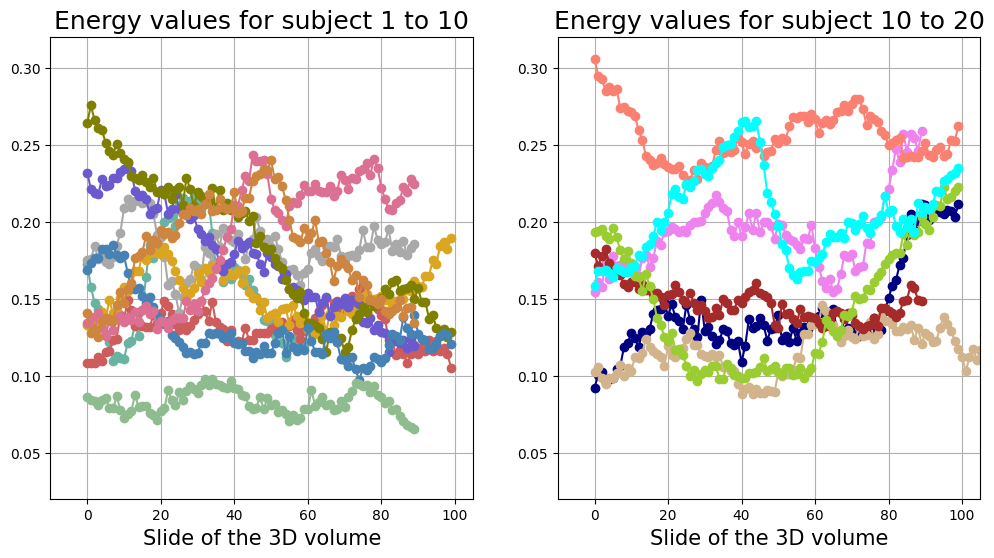

In [77]:
display_two_plot_energy(mean_energy)

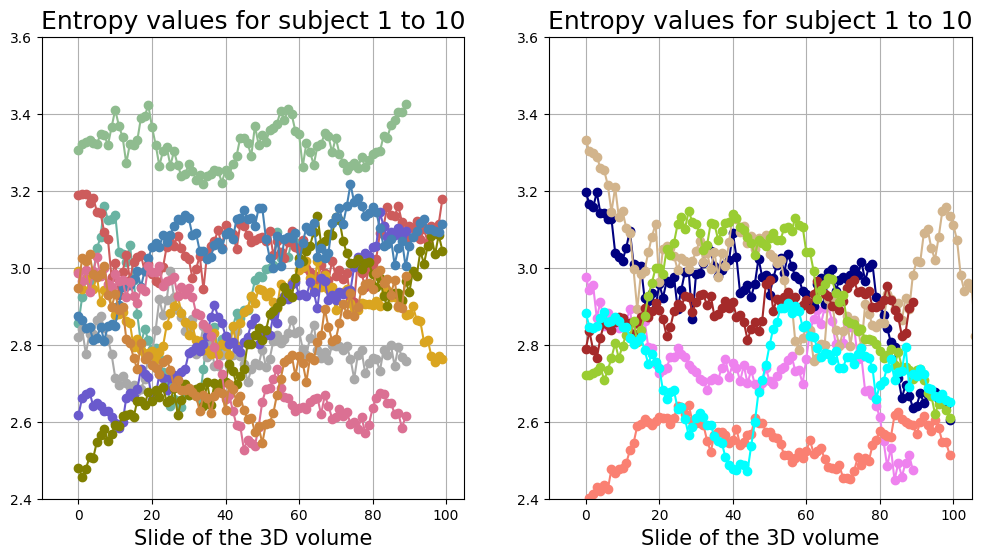

In [79]:
display_two_plot_entropy(mean_entropy)

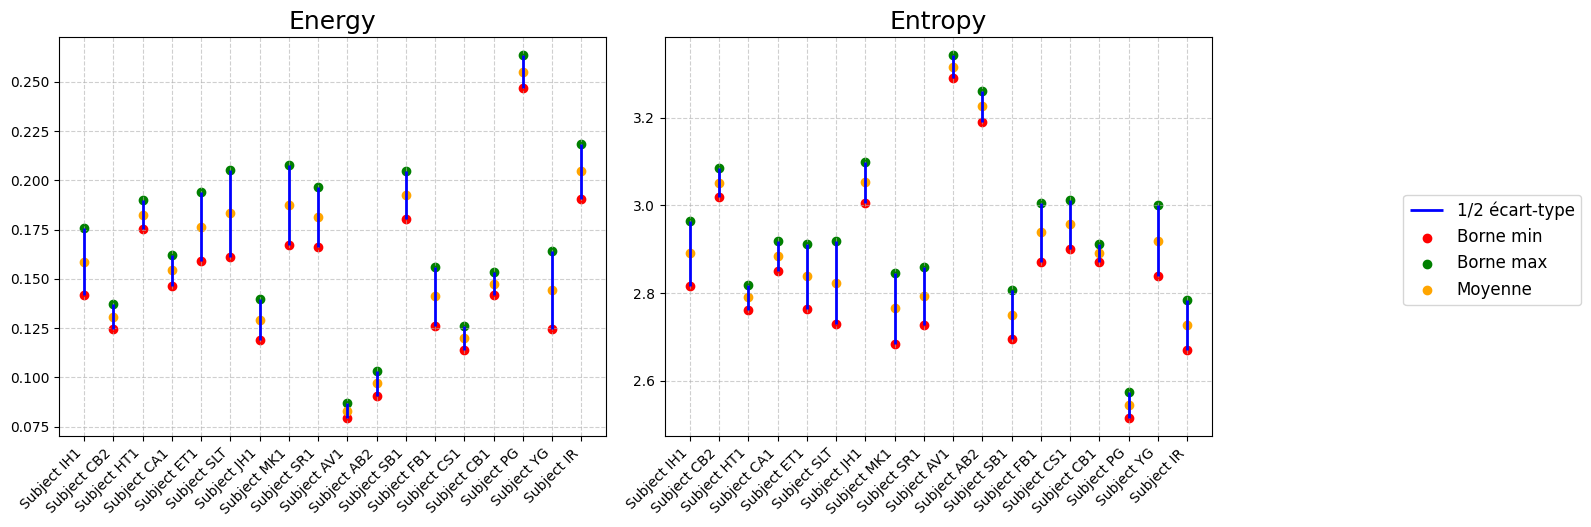

In [80]:
plot_variance_intraindividuelle_energy_entropy(mean_energy, mean_entropy, "")

### Faire pour la GM 

In [56]:
def find_file(path: str, name_file:str) -> np.ndarray :     ## UTILISER CETTE FONCTION
    """ 
    This function allows you to find a file using a path that allows you to access it and the name of the file;  

    Args:
        path (str): From the file explorer, find the file to open, right-click on it, go to "properties", copy what is written in "location" and paste it into path. IMPORTANT : Put r before the the path e.g r"C:\..." 
        name_file (str): name of the file; don't forget to write the entire name of the file, with the nrrd include, e.g "IH1 VF T  TP2.nrrd" and not only "IH1 VF T  TP2". 
        CAREFUL !! Don't forget to put "" around the path and around name_file parameter e.g below. 
    
    Returns:
        np.ndarray: the file that you want to open is an ultrasound image or a segmentation. 
    """
    full_path = os.path.join(path, name_file)
    echo, _ = nrrd.read(full_path)

    return echo 

In [75]:
# On ouvre les écho et segmentations avant réorientations
echo_NB1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\NB1\NB1 VF+ GM1", "NB1 VF T GM2.nrrd")
seg_NB1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\NB1\NB1 VF+ GM1", "Segmentation.seg.nrrd")

NB1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\NB1\NB1 VF + GM2", "NB1 VF T GM2.nrrd")
seg_NB1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\NB1\NB1 VF + GM2", "Segmentation.seg.nrrd")

# On ouvre les écho et segmentations après réorientations
echo_NB1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\NB1\NB1VF+GM1reslice", "ResliceNB1VFGM1b.nrrd")
seg_NB1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\NB1\NB1VF+GM1reslice", "Segmentation.seg.nrrd")

echo_NB1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\NB1\NB1 VF+GM2reslice", "ResliceNB1VFGM2b.nrrd")
seg_NB1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\NB1\NB1 VF+GM2reslice", "Segmentation.seg.nrrd")

In [58]:
# On ouvre les écho et segmentations avant réorientations
echo_CS1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\CS1\CS1 VF + GM1", "CS1 VF T GM.nrrd")
seg_CS1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\CS1\CS1 VF + GM1", "Segmentation.seg.nrrd")

echo_CS1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\CS1\CS1 VF+ GM2", "CS1 VF T GM2.nrrd")
seg_CS1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\CS1\CS1 VF+ GM2", "Segmentation.seg.nrrd")


# On ouvre les écho et segmentations après réorientations
echo_CS1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\CS1VF+ GM1reslice", "ResliceCS1GM VFGM1c.nrrd")
seg_CS1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\CS1VF+ GM1reslice", "Segmentation.seg.nrrd")

echo_CS1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\CS1 VF+GM2reslice", "CS1VFGM2creslice.nrrd")
seg_CS1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\CS1 VF+GM2reslice", "Segmentation.seg.nrrd")

In [59]:
# On ouvre les écho et segmentations avant réorientations
echo_HT1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\HT1\HT1 VF+ GM1", "HT1 VF T GM.nrrd")
seg_HT1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\HT1\HT1 VF+ GM1", "Segmentation.seg.nrrd")

echo_HT1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\HT1\HT1 VF + GM2", "HT1 VF T GM2.nrrd")
seg_HT1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\HT1\HT1 VF + GM2", "Segmentation.seg.nrrd")


# On ouvre les écho et segmentations après réorientations
echo_HT1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\HT1 VF+GM1reslice", "ResliceHT1VFGM1b.nrrd")
seg_HT1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\HT1 VF+GM1reslice", "Segmentation.seg.nrrd")

echo_HT1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\HT1 VF + GM2reslice", "ResliceHT1VFGM2f.nrrd")
seg_HT1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\HT1 VF + GM2reslice", "Segmentation.seg.nrrd")

In [60]:
# On ouvre les écho et segmentations avant réorientations
echo_IH1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\IH1\IH1 VF + GM1", "IH1 VF T GM.nrrd")
seg_IH1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\IH1\IH1 VF + GM1", "Segmentation.seg.nrrd")

echo_IH1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\IH1\IH1 VF + GM2", "IH1 VF T GM2.nrrd")
seg_IH1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\IH1\IH1 VF + GM2", "Segmentation.seg.nrrd")

# On ouvre les écho et segmentations après réorientations
echo_IH1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\IH1 VF+ GM1reslice", "ResliceIH1 VF GM1c.nrrd")
seg_IH1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\IH1 VF+ GM1reslice", "Segmentation.seg.nrrd")

echo_IH1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\IH1 VF+ GM2reslice", "ResliceIH1VFGM2b_2.nrrd")
seg_IH1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\IH1 VF+ GM2reslice", "Segmentation.seg.nrrd")

In [61]:
# On ouvre les écho et segmentations avant réorientations
echo_CA1_before_reslice_acq1 = find_file("C:/Users/rmohane/Desktop/base_de_donnees/TP/CA1c/CA1 VF TP1","CA1 VF T TP.nrrd")
seg_CA1_before_reslice_acq1  = find_file("C:/Users/rmohane/Desktop/base_de_donnees/TP/CA1c/CA1 VF TP1","Segmentation.seg.nrrd")

echo_CA1_before_reslice_acq2 = find_file("C:/Users/rmohane/Desktop/base_de_donnees/TP/CA1c/CA1 VF TP2","CA1 VF T TP2.nrrd")
seg_CA1_before_reslice_acq2  = find_file("C:/Users/rmohane/Desktop/base_de_donnees/TP/CA1c/CA1 VF TP2","Segmentation.seg.nrrd")


# On ouvre les écho et segmentations après réorientations
echo_CA1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\CA1 VF + GM1reslice", "ResliceCA1 VF GM1b_2.nrrd")
seg_CA1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\CA1 VF + GM1reslice", "Segmentation_4.seg.nrrd")

echo_CA1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\CA1 VF+GM2reslice", "ResliceCA1 VFGM2b.nrrd")
seg_CA1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\CA1 VF+GM2reslice", "Segmentation.seg.nrrd")

In [62]:
# On ouvre les écho et segmentations avant réorientations
echo_AB2_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\AB2 VF+ GM1", "AB2 VF T GM.nrrd")
seg_AB2_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\AB2 VF+ GM1", "Segmentation.seg.nrrd")


echo_AB2_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\AB2 VF + GM2", "AB2 VF T GM2.nrrd")
seg_AB2_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\AB2 VF + GM2", "Segmentation.seg.nrrd")


# On ouvre les écho et segmentations après réorientations
echo_AB2_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\AB2VF+ GM1reslice", "ResliceAB2 VF GM1d.nrrd")
seg_AB2_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\AB2VF+ GM1reslice", "Segmentation.seg.nrrd")


echo_AB2_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\AB2 VF+ GM2reslice", "ResliceAB2VFGM2b.nrrd")
seg_AB2_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\AB2 VF+ GM2reslice", "Segmentation.seg.nrrd")

In [63]:
# On ouvre les écho et segmentations avant réorientations
echo_JH1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\JH1 CC+GM1", "JH1 CC T GM.nrrd")
seg_JH1_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\JH1 CC+GM1", "Segmentation.seg.nrrd")


echo_JH1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\JH1CC+GM2", "JH1 CC T GM2.nrrd")
seg_JH1_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\JH1CC+GM2", "Segmentation.seg.nrrd")


# On ouvre les écho et segmentations après réorientations
echo_JH1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\JH1 CC+ GM1reslice", "ResliceJH1CCGM1.nrrd")
seg_JH1_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\JH1 CC+ GM1reslice", "Segmentation_4.seg.nrrd")


echo_JH1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\JH1 CC+ GM2reslice", "ResliceJH1CCGM2.nrrd")
seg_JH1_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\JH1 CC+ GM2reslice", "Segmentation.seg.nrrd")

In [64]:
# On ouvre les écho et segmentations avant réorientations
echo_YG_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\YG VF+ GM1", "YG VF T GM.nrrd")
seg_YG_before_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\YG VF+ GM1", "Segmentation.seg.nrrd")


echo_YG_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\YG VF+ GM2", "YG VF T GM.nrrd")
seg_YG_before_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\YG VF+ GM2", "Segmentation.seg.nrrd")


# On ouvre les écho et segmentations après réorientations
echo_YG_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\YG VF+ GM1reslice", "ResliceYG VF GM1c.nrrd")
seg_YG_after_reslice_acq1 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\YG VF+ GM1reslice", "Segmentation_1.seg.nrrd")


echo_YG_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\YG VF+ GM2reslice", "ResliceYG VFGM2b.nrrd")
seg_YG_after_reslice_acq2 = find_file(r"C:\Users\rmohane\Desktop\base_de_donnees\GM\GM_reshma\YG VF+ GM2reslice", "Segmentation_3.seg.nrrd")

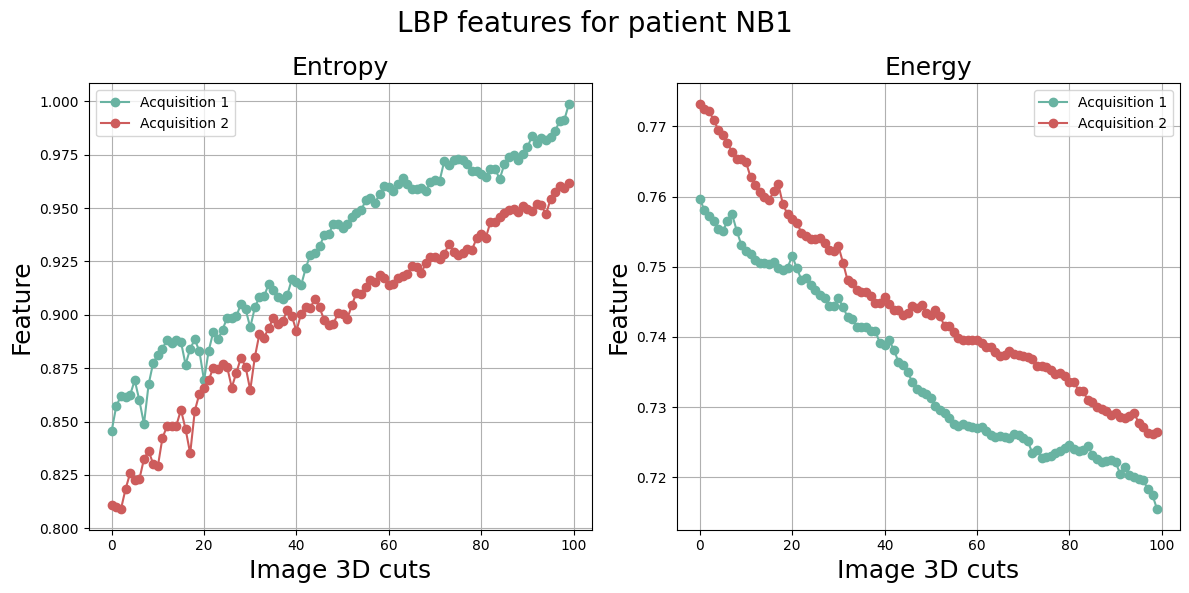

Le coefficient de variation de l'entropie entre les deux acquisitions est 2.607944111452142
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.9621534566587465


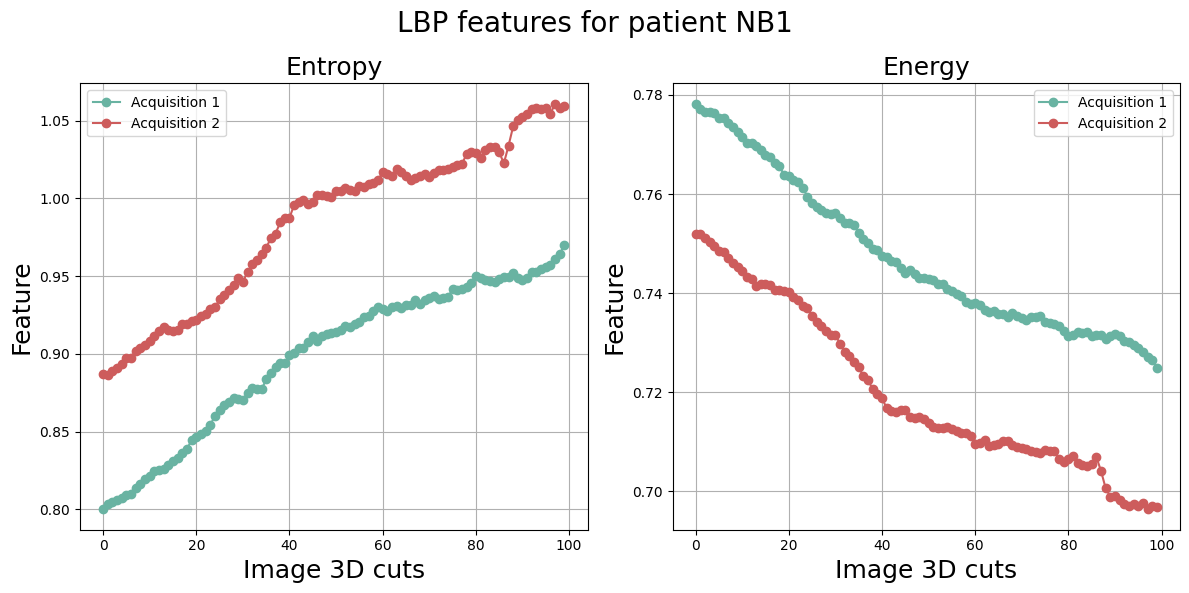

Le coefficient de variation de l'entropie entre les deux acquisitions est 6.461212656072234
Le coefficient de variation de l'énergie entre les deux acquisitions est 2.632620174438422


In [87]:
# Avant réorientation 
NB1_acq1, NB1_acq2, NB1_mean = LBP_treatement(echo_NB1_before_reslice_acq1, seg_NB1_before_reslice_acq1, 233, 333, NB1_before_reslice_acq2, seg_NB1_before_reslice_acq2, 223, 323, 8,1, "LBP features for patient NB1")

# Après réorientation  
NB1_acq1_after, NB1_acq2_after, NB1_mean_after = LBP_treatement(echo_NB1_after_reslice_acq1, seg_NB1_after_reslice_acq1, 255, 355, echo_NB1_after_reslice_acq2, seg_NB1_after_reslice_acq2, 236, 336, 8,1, "LBP features for patient NB1")

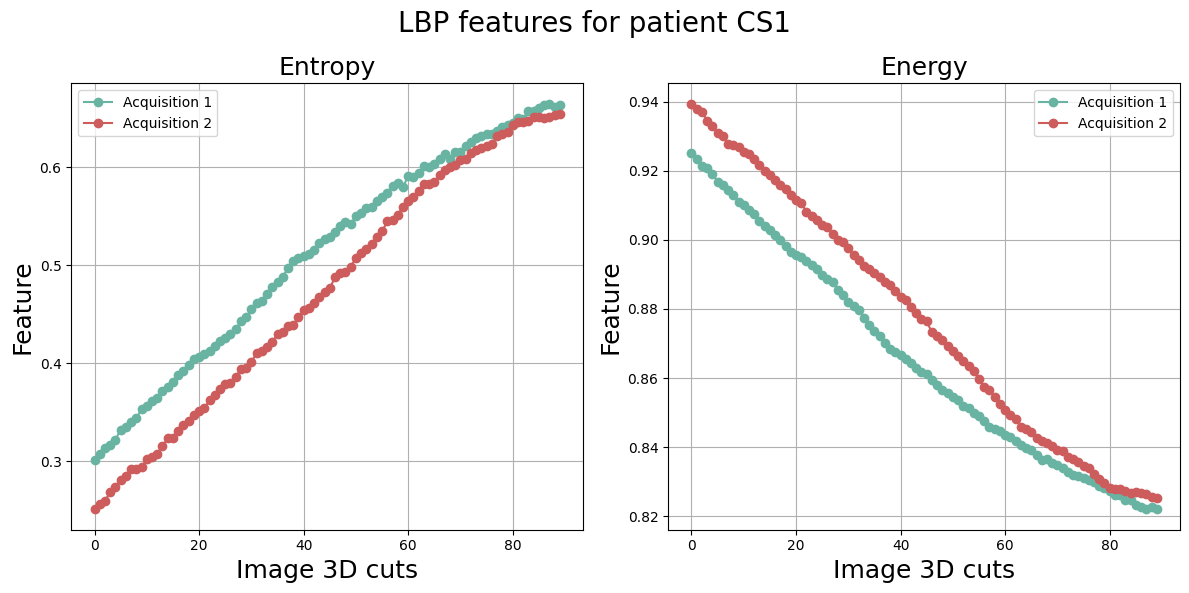

Le coefficient de variation de l'entropie entre les deux acquisitions est 6.056748342757912
Le coefficient de variation de l'énergie entre les deux acquisitions est 1.000780844346489


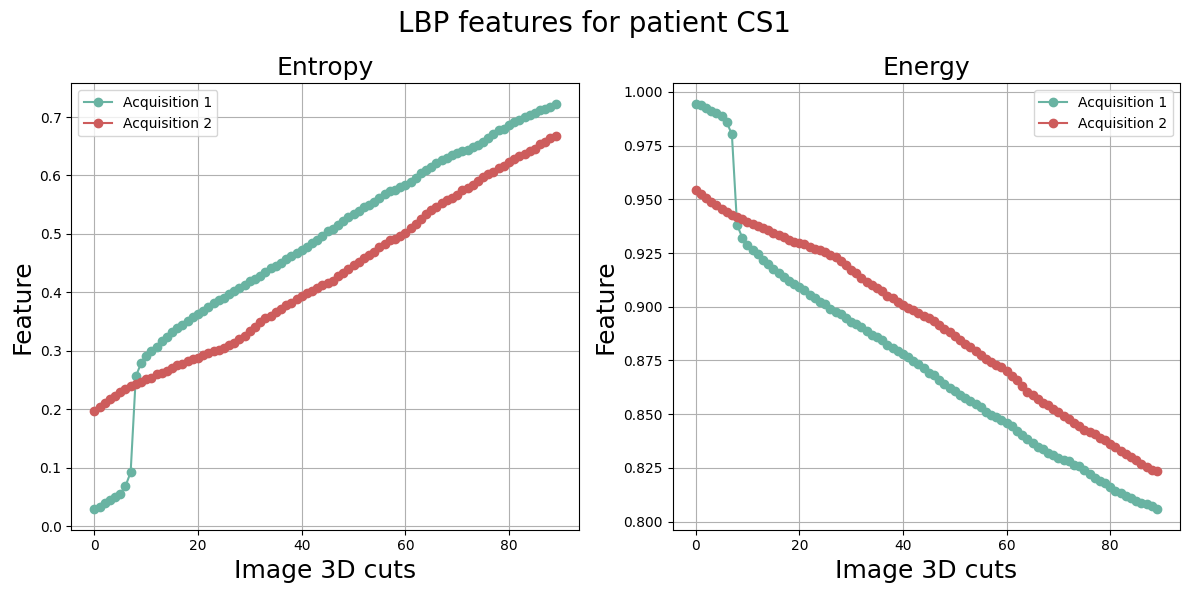

Le coefficient de variation de l'entropie entre les deux acquisitions est 13.619155745458833
Le coefficient de variation de l'énergie entre les deux acquisitions est 1.9244069091119458


In [88]:
CS1_acq1, CS1_acq2, CS1_mean = LBP_treatement(echo_CS1_before_reslice_acq1, seg_CS1_before_reslice_acq1, 215, 305, echo_CS1_before_reslice_acq2, seg_CS1_before_reslice_acq2, 228, 318, 8,1, "LBP features for patient CS1")
CS1_acq1_after, CS1_acq2_after, CS1_mean_after = LBP_treatement(echo_CS1_after_reslice_acq1, seg_CS1_after_reslice_acq1, 276, 366, echo_CS1_after_reslice_acq2, seg_CS1_after_reslice_acq2, 297, 387, 8,1, "LBP features for patient CS1")

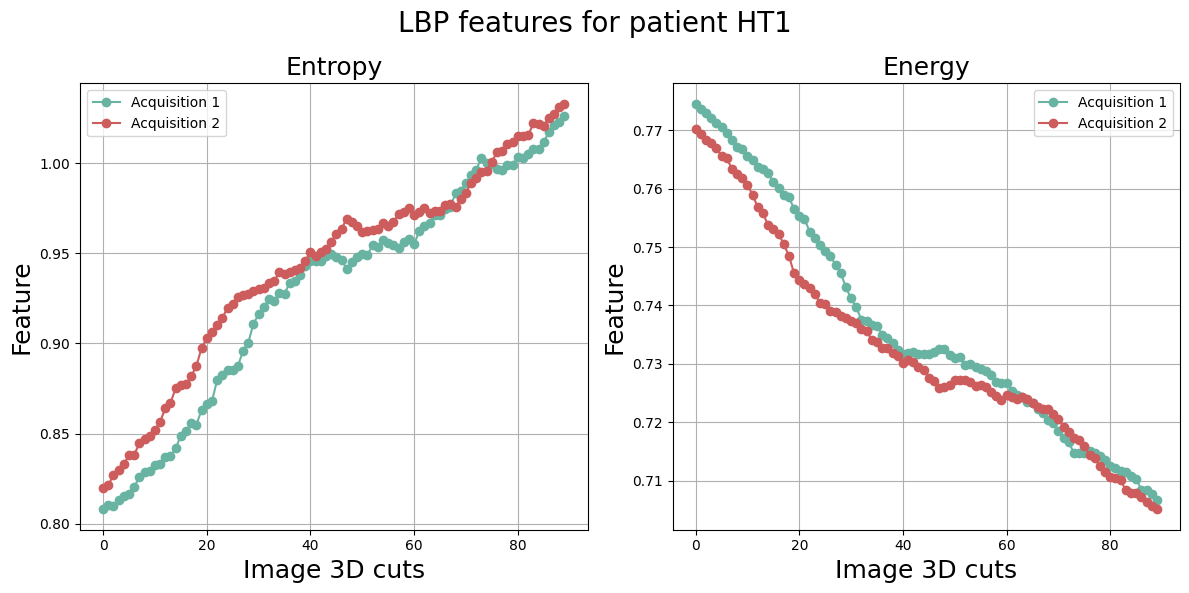

Le coefficient de variation de l'entropie entre les deux acquisitions est 1.3576896616039886
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.46869848536147346


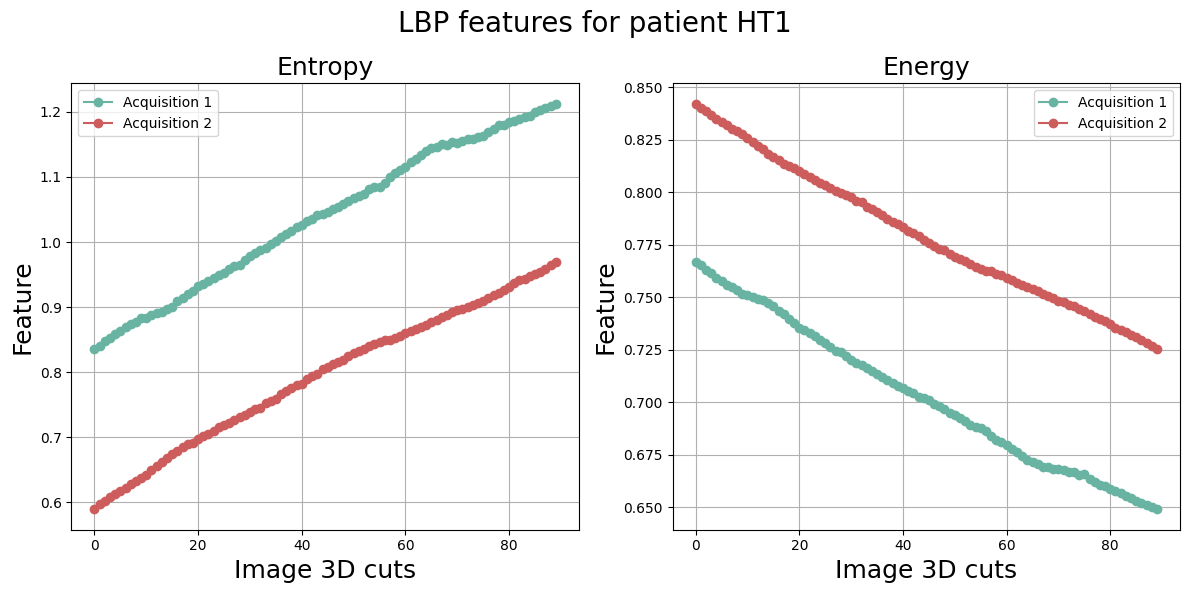

Le coefficient de variation de l'entropie entre les deux acquisitions est 18.92248991878019
Le coefficient de variation de l'énergie entre les deux acquisitions est 7.326073818080858


In [89]:
HT1_acq1, HT1_acq2, HT1_mean = LBP_treatement(echo_HT1_before_reslice_acq1, seg_HT1_before_reslice_acq1, 233, 323, echo_HT1_before_reslice_acq2, seg_HT1_before_reslice_acq2, 288, 378, 8,1, "LBP features for patient HT1")
HT1_acq1_after, HT1_acq2_after, HT1_mean_after = LBP_treatement(echo_HT1_after_reslice_acq1, seg_HT1_after_reslice_acq1, 258, 348, echo_HT1_after_reslice_acq2, seg_HT1_after_reslice_acq2, 260, 350, 8,1, "LBP features for patient HT1")

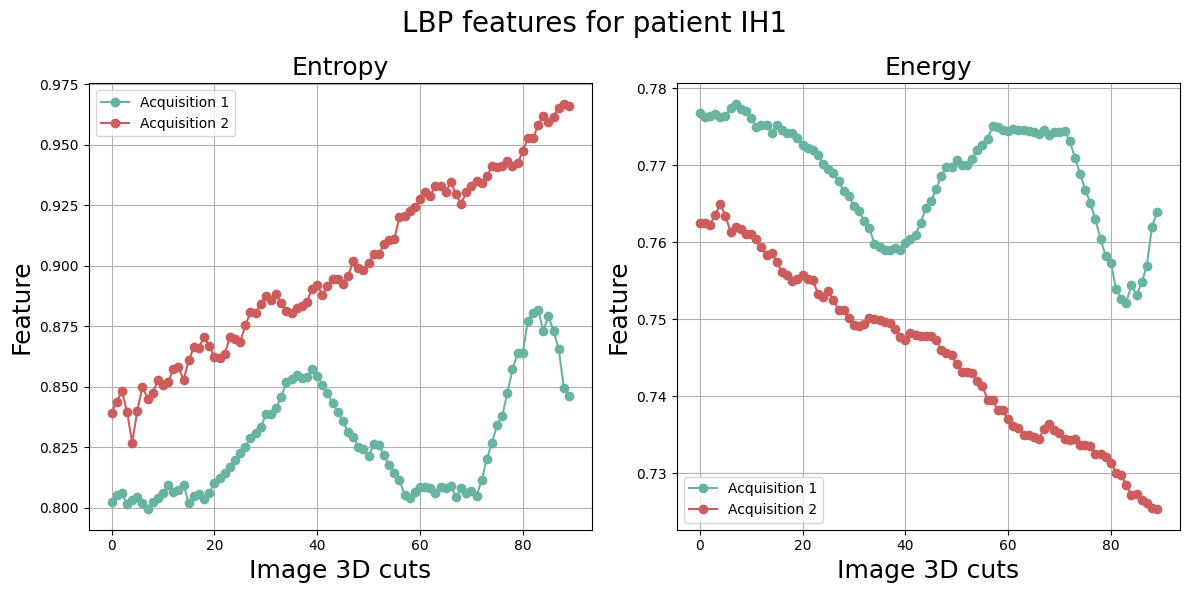

Le coefficient de variation de l'entropie entre les deux acquisitions est 6.5227058273341365
Le coefficient de variation de l'énergie entre les deux acquisitions est 2.359625846029254


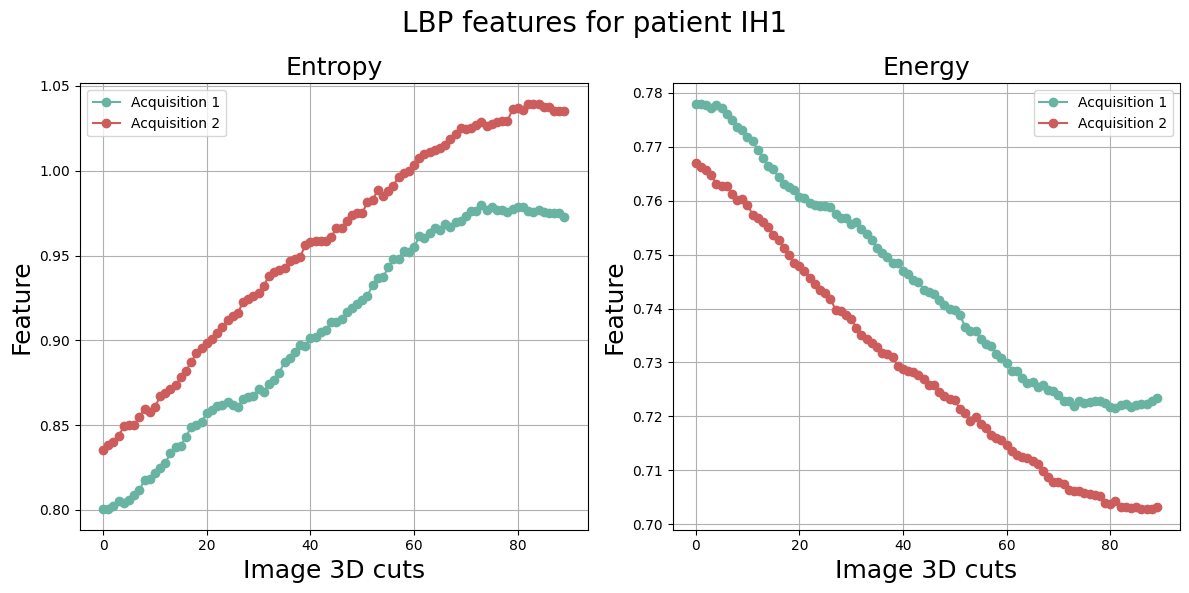

Le coefficient de variation de l'entropie entre les deux acquisitions est 3.870267557563719
Le coefficient de variation de l'énergie entre les deux acquisitions est 1.552770125258105


In [93]:
IH1_acq1, IH1_acq2, IH1_mean = LBP_treatement(echo_IH1_before_reslice_acq1, seg_IH1_before_reslice_acq1, 266, 356, echo_IH1_before_reslice_acq2, seg_IH1_before_reslice_acq2, 249, 339, 8,1, "LBP features for patient IH1")
IH1_acq1_after, IH1_acq2_after, IH1_mean_after = LBP_treatement(echo_IH1_after_reslice_acq1, seg_IH1_after_reslice_acq1, 254, 344, echo_IH1_after_reslice_acq2, seg_IH1_after_reslice_acq2, 221, 311, 8,1, "LBP features for patient IH1")

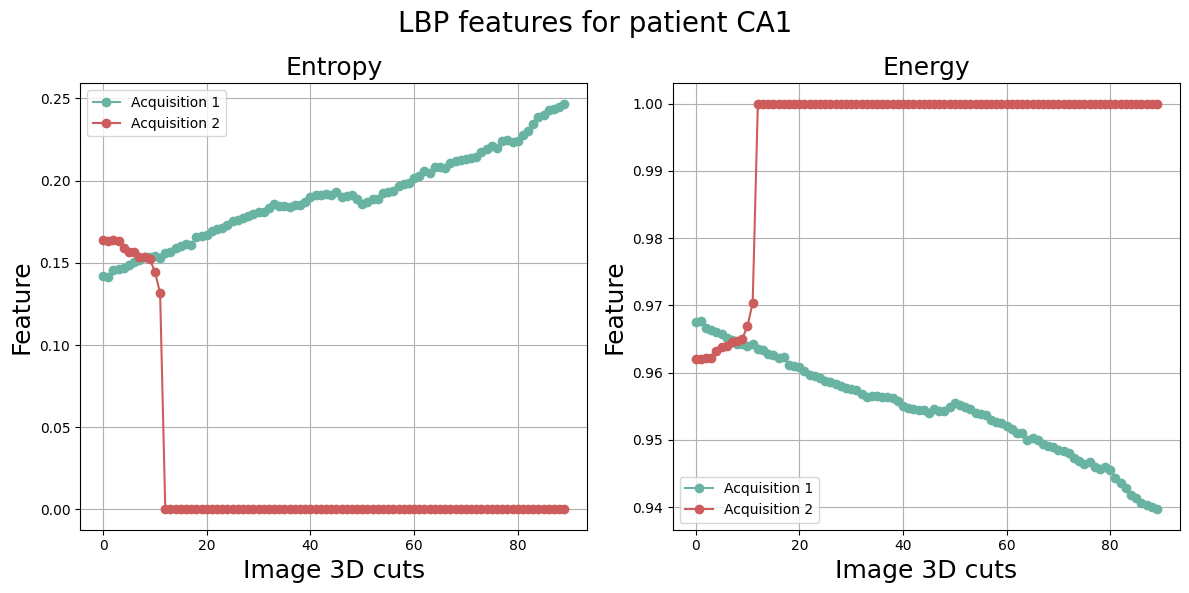

Le coefficient de variation de l'entropie entre les deux acquisitions est 123.60886623415499
Le coefficient de variation de l'énergie entre les deux acquisitions est 3.2022095035925595


In [ ]:
CA1_acq1, CA1_acq2, CA1_mean = LBP_treatement(echo_CA1_before_reslice_acq1, seg_CA1_before_reslice_acq1, 299, 389, echo_CA1_before_reslice_acq2, seg_CA1_before_reslice_acq2, 312, 402, 8,1, "LBP features for patient CA1")
CA1_acq1_after, CA1_acq2_after, CA1_mean_after = LBP_treatement(echo_CA1_before_reslice_acq1, seg_CA1_before_reslice_acq1, 299, 389, echo_CA1_before_reslice_acq2, seg_CA1_before_reslice_acq2, 312, 402, 8,1, "LBP features for patient CA1")

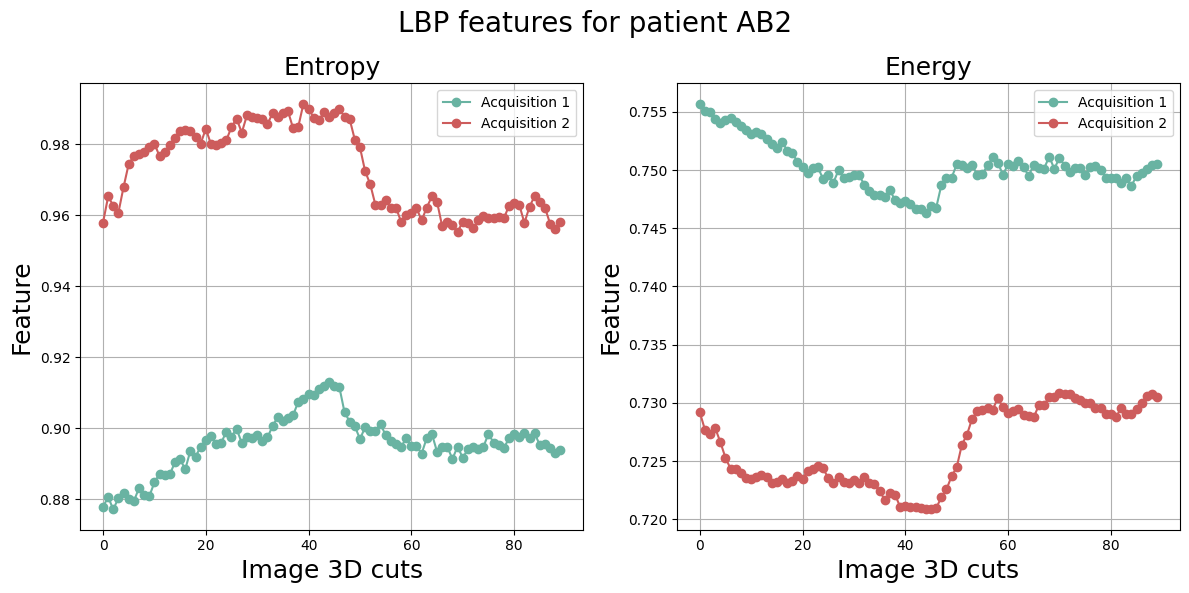

Le coefficient de variation de l'entropie entre les deux acquisitions est 5.898847451228659
Le coefficient de variation de l'énergie entre les deux acquisitions est 2.336478033986941


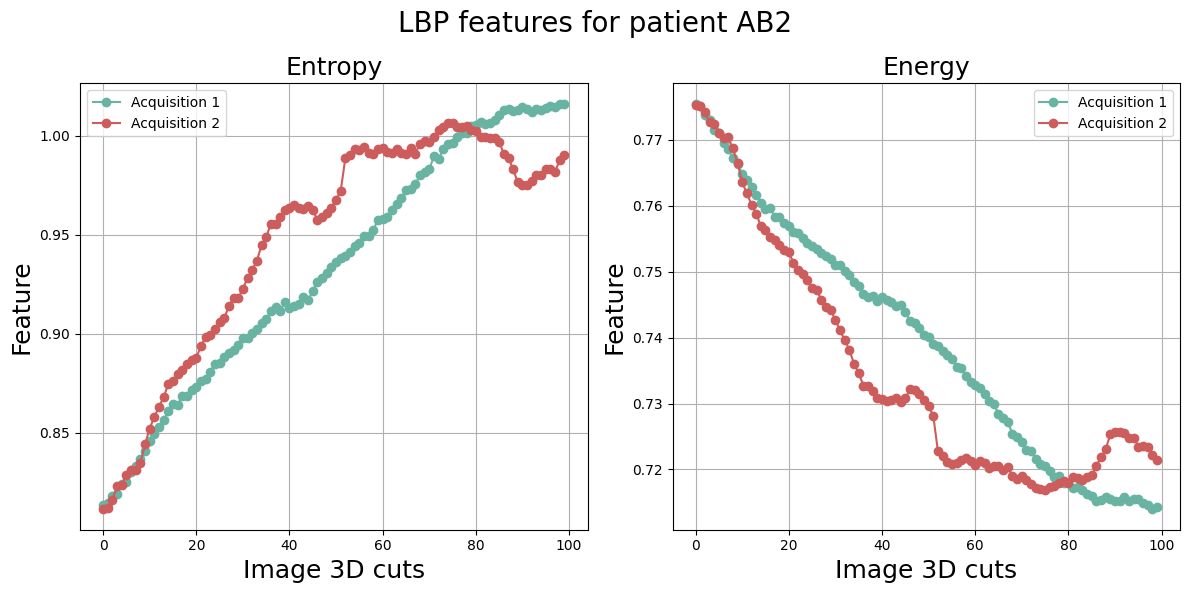

Le coefficient de variation de l'entropie entre les deux acquisitions est 2.0982228849603746
Le coefficient de variation de l'énergie entre les deux acquisitions est 0.8409108118373593


In [92]:
AB2_acq1, AB2_acq2, AB2_mean = LBP_treatement(echo_AB2_before_reslice_acq1, seg_AB2_before_reslice_acq1, 295, 385, echo_AB2_before_reslice_acq2, seg_AB2_before_reslice_acq2, 312, 402, 8,1, "LBP features for patient AB2")
AB2_acq1_after, AB2_acq2_after, AB2_mean_after = LBP_treatement(echo_AB2_after_reslice_acq1, seg_AB2_after_reslice_acq1, 240, 340, echo_AB2_after_reslice_acq2, seg_AB2_after_reslice_acq2, 229, 329, 8,1, "LBP features for patient AB2")

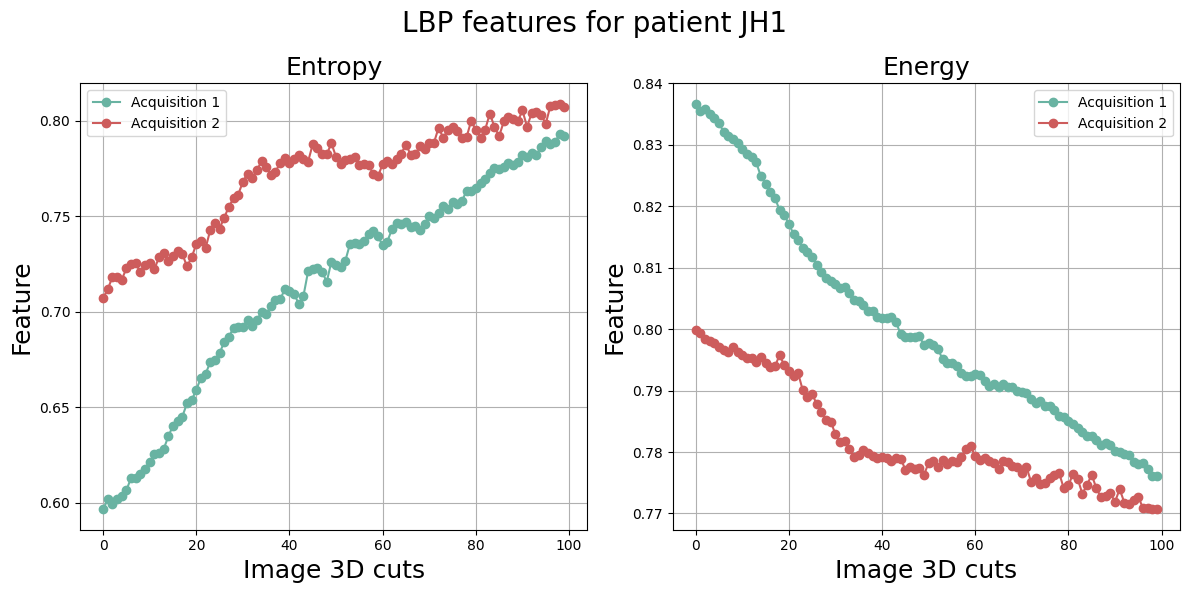

Le coefficient de variation de l'entropie entre les deux acquisitions est 6.145695150152751
Le coefficient de variation de l'énergie entre les deux acquisitions est 1.88596482619597


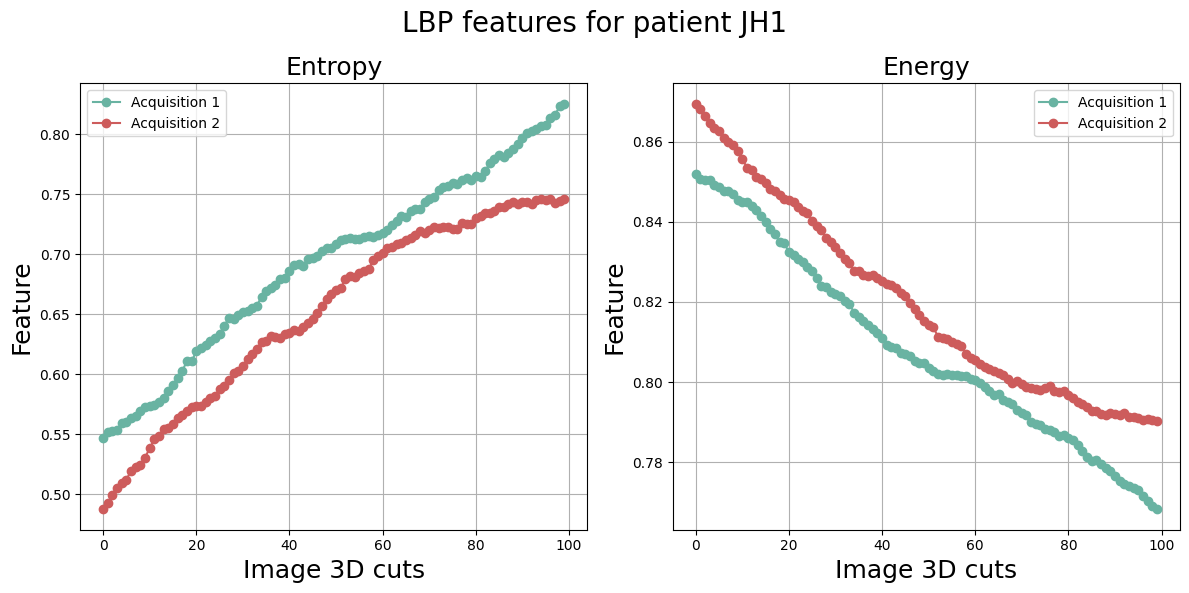

Le coefficient de variation de l'entropie entre les deux acquisitions est 4.532278900235339
Le coefficient de variation de l'énergie entre les deux acquisitions est 1.062338743129441


In [95]:
JH1_acq1, JH1_acq2, JH1_mean = LBP_treatement(echo_JH1_before_reslice_acq1, seg_JH1_before_reslice_acq1, 207, 307, echo_JH1_before_reslice_acq2, seg_JH1_before_reslice_acq2, 267, 367, 8,1, "LBP features for patient JH1")
JH1_acq1_after, JH1_acq2_after, JH1_mean_after = LBP_treatement(echo_JH1_after_reslice_acq1, seg_JH1_after_reslice_acq1, 217, 317, echo_JH1_after_reslice_acq2, seg_JH1_after_reslice_acq2, 233, 333, 8,1, "LBP features for patient JH1")

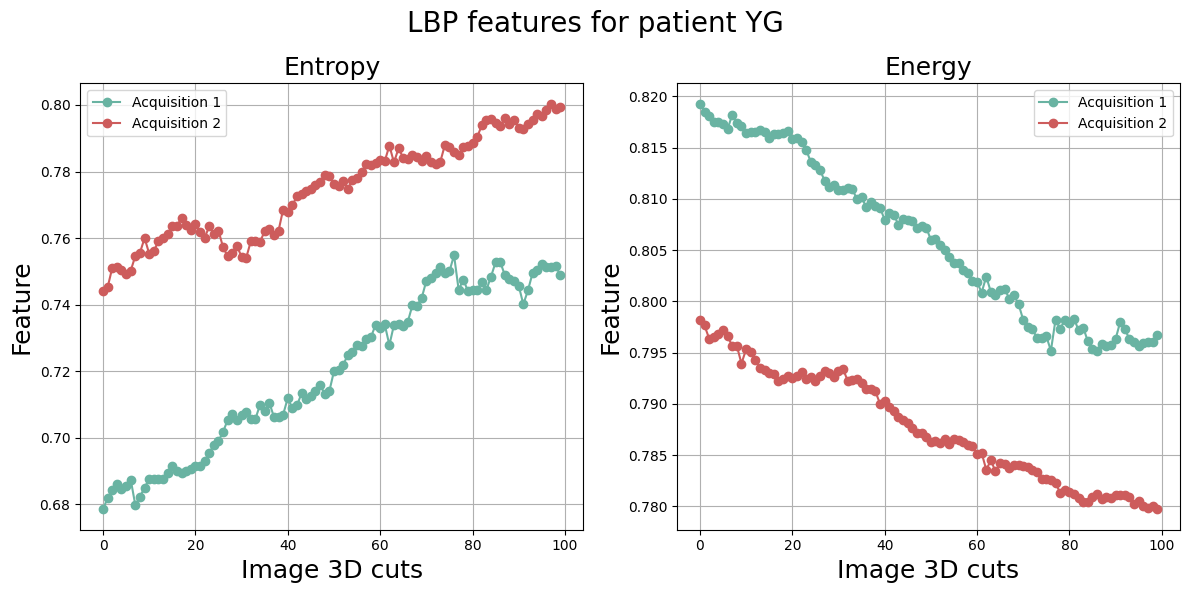

Le coefficient de variation de l'entropie entre les deux acquisitions est 5.28460793983643
Le coefficient de variation de l'énergie entre les deux acquisitions est 1.6465570387924031


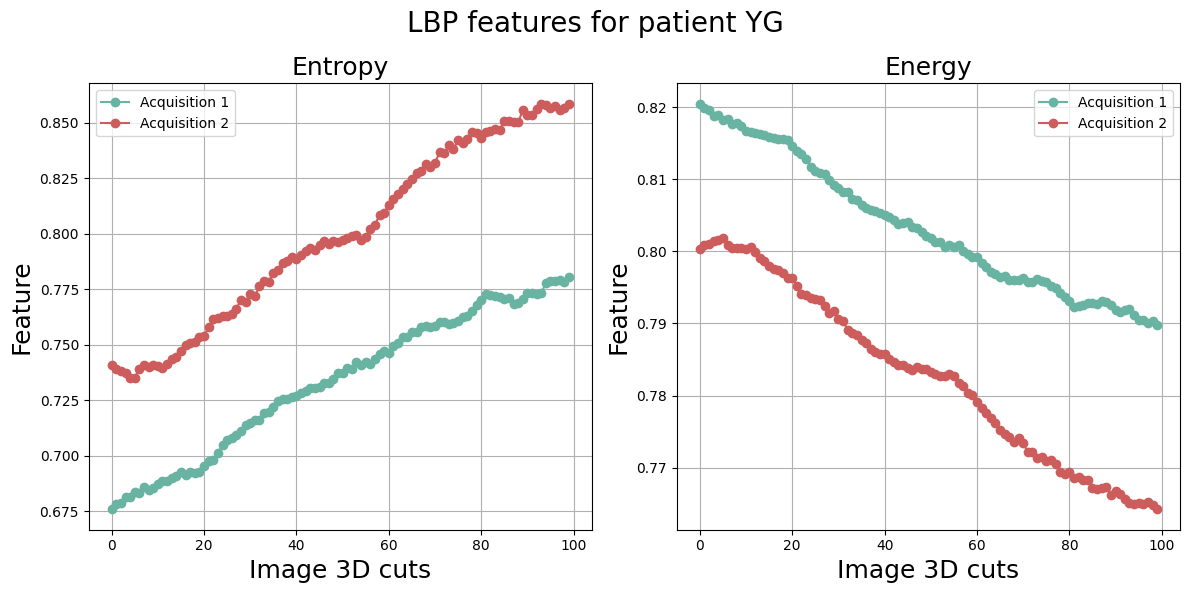

Le coefficient de variation de l'entropie entre les deux acquisitions est 6.1317162495269075
Le coefficient de variation de l'énergie entre les deux acquisitions est 1.8597657712733016


In [96]:
YG_acq1, YG_acq2, YG_mean = LBP_treatement(echo_YG_before_reslice_acq1, seg_YG_before_reslice_acq1, 294, 394, echo_YG_before_reslice_acq2, seg_YG_before_reslice_acq2, 305,405, 8,1, "LBP features for patient YG")
YG_acq1_after, YG_acq2_after, YG_mean_after = LBP_treatement(echo_YG_after_reslice_acq1, seg_YG_after_reslice_acq1, 247, 347, echo_YG_after_reslice_acq2, seg_YG_after_reslice_acq2, 249,349, 8,1, "LBP features for patient YG")

In [97]:
entropy_acq1 = [IH1_acq1_after[0], HT1_acq1_after[0], 
            JH1_acq1_after[0], AB2_acq1_after[0], CS1_acq1_after[0], YG_acq1_after[0], NB1_acq1_after[0]]

entropy_acq2 = [IH1_acq2_after[0], HT1_acq2_after[0], 
            JH1_acq2_after[0], AB2_acq2_after[0], CS1_acq2_after[0], YG_acq2_after[0], NB1_acq2_after[0]]

In [98]:
energy_acq1 = [IH1_acq1_after[1], HT1_acq1_after[1], 
            JH1_acq1_after[1], AB2_acq1_after[1], CS1_acq1_after[1], YG_acq1_after[1], NB1_acq1_after[1]]

energy_acq2 = [IH1_acq2_after[1], HT1_acq2_after[1], 
            JH1_acq2_after[1], AB2_acq2_after[1], CS1_acq2_after[1], YG_acq2_after[1], NB1_acq2_after[1]]

In [99]:
# calculde la moyenne entre la première et deuxieme acquisition
mean_energy = []
mean_entropy = []

for i in range(len(energy_acq1)):  # boucle sur les patients
    nb_coupes_i = len(energy_acq1[i])  # nombre de coupes pour le patient i
    patient_energy = []
    patient_entropy = []
    
    for j in range(nb_coupes_i):  # boucle sur les coupes de ce patient
        mean_e = (energy_acq1[i][j] + energy_acq2[i][j]) / 2
        mean_h = (entropy_acq1[i][j] + entropy_acq2[i][j]) / 2
        patient_energy.append(mean_e)
        patient_entropy.append(mean_h)
    
    mean_energy.append(patient_energy)
    mean_entropy.append(patient_entropy)

In [100]:
feature1_mean = [IH1_mean_after[0], HT1_mean_after[0], 
            JH1_mean_after[0], AB2_mean_after[0], CS1_mean_after[0], YG_mean_after[0], NB1_mean_after[0]]

feature2_mean = [IH1_mean_after[1], HT1_mean_after[1], 
            JH1_mean_after[1], AB2_mean_after[1], CS1_mean_after[1], YG_mean_after[1], NB1_mean_after[1]]

In [102]:
def display_two_plot_energy(feature1_mean): 
    plt.figure(figsize=(12,6))
    colormap = ["#69B3A2","indianred","darkgrey","goldenrod","slateblue","olive","steelblue","palevioletred",
                "peru", "darkseagreen"]
    colormap2 = ["violet","navy","tan","brown", "salmon", "yellowgreen", "aqua",
                "deepskyblue"]
    patient_label = ["IH1", "CB2", "HT1", "CA1", "ET1", "SLT", "JH1", "MK1", "SR1", "AV1", "AB2", "SB1", "FB1", "CS1", "CB1", "PG", "YG","IR"]
    feature1_mean_x = feature1_mean[:10]
    feature1_mean_xx = feature1_mean[11:]
    plt.subplot(1,2,1)
   
    for j in range(len(feature1_mean_x)):
        plt.plot(feature1_mean_x[j], marker = 'o', color = colormap[j], label = patient_label[j])
        # plt.xlim(-10,105)
        # plt.ylim(0.02,0.32)
        plt.grid(True)
        plt.title("Energy values for subject 1 to 10", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

    plt.subplot(1,2,2)
   
    for j in range(len(feature1_mean_xx)):
        plt.plot(feature1_mean_xx[j], marker = 'o', color = colormap2[j], label = patient_label[j])
        # plt.xlim(-10,105)
        # plt.ylim(0.02,0.32)
        plt.grid(True)
        plt.title("Energy values for subject 10 to 20", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

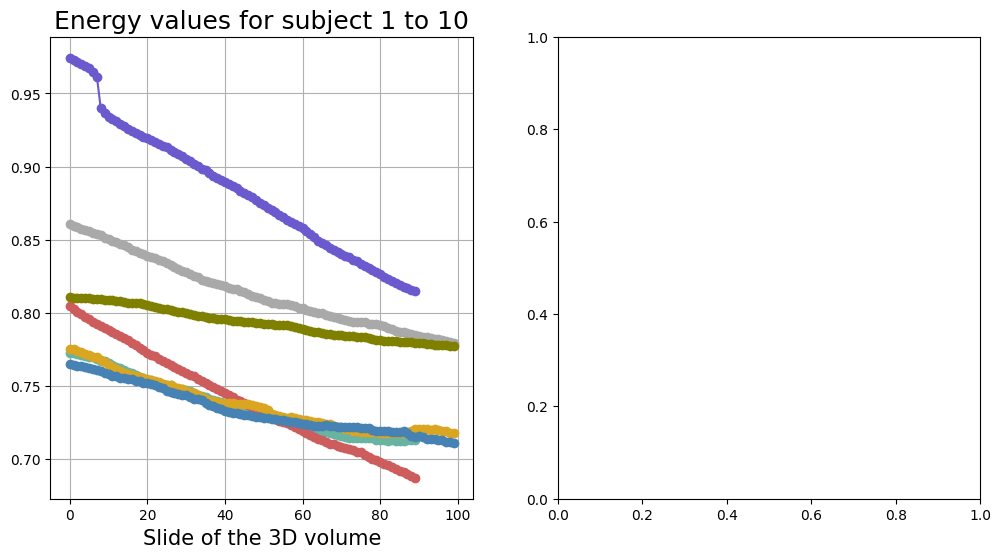

In [103]:
display_two_plot_energy(mean_energy)

In [105]:
def display_two_plot_entropy(feature1_mean): 
    plt.figure(figsize=(12,6))
    colormap = ["#69B3A2","indianred","darkgrey","goldenrod","slateblue","olive","steelblue","palevioletred",
                "peru", "darkseagreen"]
    colormap2 = ["violet","navy","tan","brown", "salmon", "yellowgreen", "aqua",
                "deepskyblue"]
    patient_label = ["IH1", "CB2", "HT1", "CA1", "ET1", "SLT", "JH1", "MK1", "SR1", "AV1", "AB2", "SB1", "FB1", "CS1", "CB1", "PG", "YG","IR"]
    feature1_mean_x = feature1_mean[:10]
    feature1_mean_xx = feature1_mean[11:]
    plt.subplot(1,2,1)
   
    for j in range(len(feature1_mean_x)):
        plt.plot(feature1_mean_x[j], marker = 'o', color = colormap[j], label = patient_label[j])
        # plt.xlim(-10,105)
        # plt.ylim(2.4, 3.6)
        plt.grid(True)
        plt.title("Entropy values for subject 1 to 10", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)

    plt.subplot(1,2,2)
   
    for j in range(len(feature1_mean_xx)):
        plt.plot(feature1_mean_xx[j], marker = 'o', color = colormap2[j], label = patient_label[j])
        # plt.xlim(-10,105)
        # plt.ylim(2.4, 3.6)
        plt.grid(True)
        plt.title("Entropy values for subject 1 to 10", fontsize=18)
        plt.xlabel("Slide of the 3D volume", fontsize = 15)


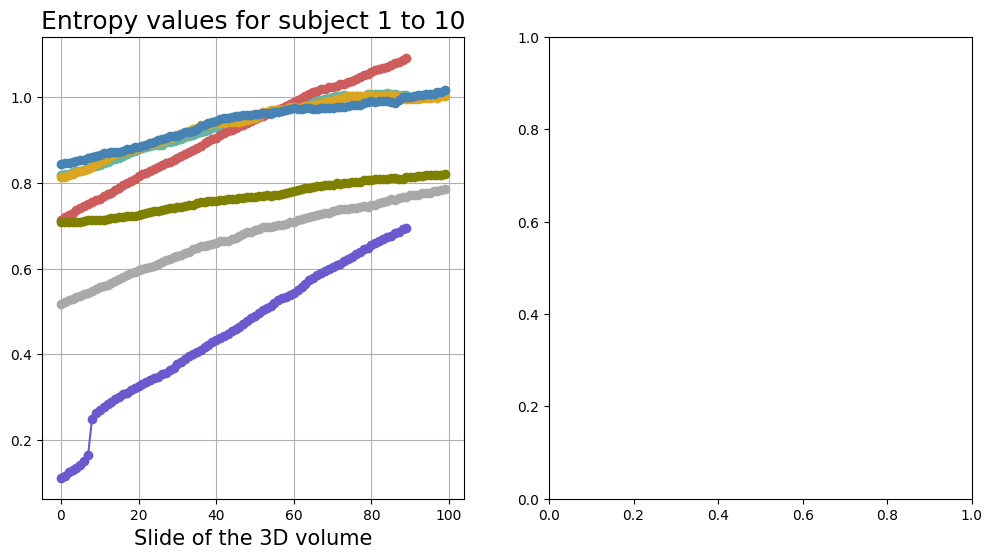

In [106]:
display_two_plot_entropy(mean_entropy)